In [36]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA, NMF, FactorAnalysis
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS, Isomap
import deep_sdf.workspace as ws
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
import time

In [37]:
# 1. Load the latent vectors from your trained model
experiment_dir = 'examples/ADNI_1_L_No_MCI/minimal_eikonal_gmm'
checkpoint = 'latest'

# Load latent vectors
latent_vectors = ws.load_latent_vectors(experiment_dir, checkpoint)
X = latent_vectors.cpu().numpy()

print(f'Loaded latent vectors with shape: {X.shape}')


Loaded latent vectors with shape: (696, 256)


In [ ]:
# 2. Load the filenames of the meshes and labels
import json

with open(os.path.join(experiment_dir, 'specs.json'), 'r') as f:
    specs = json.load(f)

mesh_root = specs.get('DataSourceMesh', specs['DataSource'])
train_split_file = specs.get('TrainSplit')
test_split_file = specs.get('TestSplit')
labels_path = os.path.join(mesh_root, 'labels.pt')

def load_split(path):
    if not path:
        return []
    with open(path, 'r') as f:
        return json.load(f)

train_split = load_split(train_split_file)
test_split = load_split(test_split_file)

# Combine train + test (unique), but fall back if sizes mismatch latent vectors
split_list = []
seen = set()
for name in train_split + test_split:
    if name not in seen:
        split_list.append(name)
        seen.add(name)

valid_filenames = split_list
if X.shape[0] != len(valid_filenames):
    if len(train_split) == X.shape[0]:
        print('Latent count matches train split; using train split only.')
        valid_filenames = train_split
    else:
        print('Warning: latent count does not match split sizes.')

print(f'Train split: {len(train_split)}')
print(f'Test split: {len(test_split)}')
print(f'Using {len(valid_filenames)} filenames for label matching')

mesh_params = []
if os.path.exists(labels_path):
    print(f'Loading labels from {labels_path}')
    all_labels = torch.load(labels_path, map_location='cpu')
    label_map = all_labels
    if not isinstance(all_labels, dict):
        if hasattr(all_labels, '__len__') and len(all_labels) == len(valid_filenames):
            label_map = {}
            for idx, filename in enumerate(valid_filenames):
                base_name = os.path.splitext(os.path.basename(filename))[0]
                label_map[base_name] = all_labels[idx]
        else:
            print('Warning: labels are not a dict and length does not match filenames; skipping label lookup.')
            label_map = {}

    for filename in valid_filenames:
        base_name = os.path.splitext(os.path.basename(filename))[0]
        params = {
            'diagnosis': -1,
            'age': float('nan'),
            'sex': -1,
            'volume': float('nan'),
        }
        if base_name in label_map:
            label = label_map[base_name]
            params['diagnosis'] = int(label[0].item())
            params['age'] = float(label[1].item())
            params['sex'] = int(label[2].item())
            params['volume'] = float(label[3].item())
        else:
            print(f'Warning: No label found for {base_name}')
        mesh_params.append(params)
else:
    print(f'labels.pt not found at {labels_path}')


In [39]:
# Extract parameters for visualization
diagnosis = np.array([p.get('diagnosis', -1) for p in mesh_params])
age = np.array([p.get('age', float('nan')) for p in mesh_params], dtype=float)
sex = np.array([p.get('sex', -1) for p in mesh_params])
volume = np.array([p.get('volume', float('nan')) for p in mesh_params], dtype=float)

# Create ground truth factors array for SAP calculation
ground_truth_factors = np.column_stack((diagnosis, age, sex, volume))
factor_names = ['diagnosis', 'age', 'sex', 'volume']


In [40]:
# AD prediction imports (independent cell)
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


In [ ]:
# Predict AD (diagnosis == 1) from 256D latent vectors using a small MLP
mask = diagnosis >= 0
X_valid = X[mask]
y = (diagnosis[mask] == 1).astype(np.int64)

if X_valid.shape[1] != 256:
    print(f'Warning: expected 256D latent, got {X_valid.shape[1]}D')

if len(np.unique(y)) < 2:
    raise ValueError('Need at least two classes for AD prediction. Check labels.')

X_train, X_val, y_train, y_val = train_test_split(
    X_valid, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train)
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val)
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 2),
).to(device)

class_counts = np.bincount(y_train)
class_weights = torch.tensor(
    len(y_train) / (2.0 * class_counts), dtype=torch.float32, device=device
)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(200):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

model.eval()
with torch.no_grad():
    val_logits = []
    val_targets = []
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        val_logits.append(logits.cpu())
        val_targets.append(yb)

val_logits = torch.cat(val_logits, dim=0)
val_targets = torch.cat(val_targets, dim=0).numpy()
val_probs = torch.softmax(val_logits, dim=1)[:, 1].numpy()
val_preds = (val_probs >= 0.5).astype(np.int64)

acc = accuracy_score(val_targets, val_preds)
auc = roc_auc_score(val_targets, val_probs)
print(f'Validation accuracy: {acc:.3f}  AUROC: {auc:.3f}')
print(classification_report(val_targets, val_preds, digits=3))


In [41]:
# 3. Apply various dimensionality reduction and factor analysis techniques
plt.figure(figsize=(20, 16))
results = {}
transformed_latents = {}
distances_all = []


<Figure size 2000x1600 with 0 Axes>

In [ ]:
# 3.1. PCA
print('Applying PCA...')
pca = PCA(n_components=4)
Y_pca = pca.fit_transform(X)
results['PCA'] = Y_pca
transformed_latents['PCA'] = Y_pca
print(f'PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}')

# check if volume is encoded as distance from the origin
center = np.mean(Y_pca, axis=0)
distances = np.sqrt(np.sum((Y_pca - center) ** 2, axis=1))
mask = np.isfinite(volume)
if np.any(mask):
    print(f'Correlation between distance from origin and volume: {np.corrcoef(distances[mask], volume[mask])[0, 1]:.4f}')
else:
    print('No finite volume values to compute distance correlation.')
distances_pca = distances
distances_all.append(distances)

# 3.2. HLLE+ICA
best_corr = -np.inf
best_Y_hlle_ica = None
best_params = None

# Loop over a range of n_neighbors and latent space dimensions
for n_neighbors in range(300, 320, 10):
    for n_components in [4]:
        try:
            hlle = LocallyLinearEmbedding(n_neighbors=n_neighbors,
                                           n_components=n_components,
                                           method='hessian',
                                           eigen_solver='dense')
            Z = hlle.fit_transform(X)

            ica = FastICA(n_components=n_components, random_state=42)
            Y_hlle_ica = ica.fit_transform(Z)
            #Y_hlle_ica = Z

            correlations = []
            mask = diagnosis >= 0
            for comp in range(n_components):
                if np.any(mask):
                    corr = np.corrcoef(Y_hlle_ica[mask, comp], diagnosis[mask])[0, 1]
                else:
                    corr = float('nan')
                correlations.append(corr)
            print(correlations)

            best_component_idx = max(range(n_components), key=lambda i: abs(correlations[i]))
            best_component_corr = correlations[best_component_idx]

            print(f'n_neighbors: {n_neighbors}, n_components: {n_components}, '
                  f'best component correlation: {best_component_corr:.4f}')

            if abs(best_component_corr) > best_corr:
                best_corr = best_component_corr
                best_Y_hlle_ica = Y_hlle_ica
                best_params = (n_neighbors, n_components, best_component_idx)

        except Exception as e:
            print(f'Failed for n_neighbors: {n_neighbors}, n_components: {n_components} due to: {e}')

if best_Y_hlle_ica is not None:
    print('\nBest parameter set:')
    print(f'n_neighbors: {best_params[0]}, n_components: {best_params[1]}, best component: {best_params[2]} best correlation: {best_corr:.4f}')
    results['HLLE+ICA'] = best_Y_hlle_ica
    transformed_latents['HLLE+ICA'] = best_Y_hlle_ica
else:
    print('No valid HLLE+ICA transformation found.')


In [ ]:
# 3.3. NMF
print('Applying NMF...')
X_min = X.min()
if X_min < 0:
    X_offset = X - X_min
else:
    X_offset = X.copy()

best_corr_nmf = None
best_W_nmf = None
best_nmf_params = None

for n_components in [4]:
    try:
        nmf = NMF(n_components=n_components, random_state=42, max_iter=10000)
        W = nmf.fit_transform(X_offset)

        correlations = []
        mask = diagnosis >= 0
        for comp in range(n_components):
            if np.any(mask):
                corr = np.corrcoef(W[mask, comp], diagnosis[mask])[0, 1]
            else:
                corr = float('nan')
            correlations.append(corr)

        best_component_corr = max(correlations, key=abs)
        print(f'n_components: {n_components}, best component correlation (diagnosis): {best_component_corr:.4f}')

        if best_corr_nmf is None or abs(best_component_corr) > abs(best_corr_nmf):
            best_corr_nmf = best_component_corr
            best_W_nmf = W
            best_nmf_params = n_components

    except Exception as e:
        print(f'NMF failed for n_components: {n_components} due to: {e}')

if best_W_nmf is not None:
    results['NMF'] = best_W_nmf
    transformed_latents['NMF'] = best_W_nmf


In [ ]:
# 3.4. Factor Analysis
print('Applying Factor Analysis...')
fa = FactorAnalysis(n_components=4, random_state=42)
Y_fa = fa.fit_transform(X)
results['FA'] = Y_fa
transformed_latents['FA'] = Y_fa

center = np.mean(Y_fa, axis=0)
distances = np.sqrt(np.sum((Y_fa - center) ** 2, axis=1))
mask = np.isfinite(volume)
if np.any(mask):
    print(f'Correlation between distance from origin and volume: {np.corrcoef(distances[mask], volume[mask])[0, 1]:.4f}')
else:
    print('No finite volume values to compute distance correlation.')
distances_Y_fa = distances
distances_all.append(distances)


In [ ]:
# 3.5. ICA
print('Applying ICA...')
ica = FastICA(n_components=4, random_state=42)
Y_ica = ica.fit_transform(X)
results['ICA'] = Y_ica
transformed_latents['ICA'] = Y_ica

center = np.mean(Y_ica, axis=0)
distances = np.sqrt(np.sum((Y_ica - center) ** 2, axis=1))
mask = np.isfinite(volume)
if np.any(mask):
    print(f'Correlation between distance from origin and volume: {np.corrcoef(distances[mask], volume[mask])[0, 1]:.4f}')
else:
    print('No finite volume values to compute distance correlation.')
distances_Y_ica = distances
distances_all.append(distances)


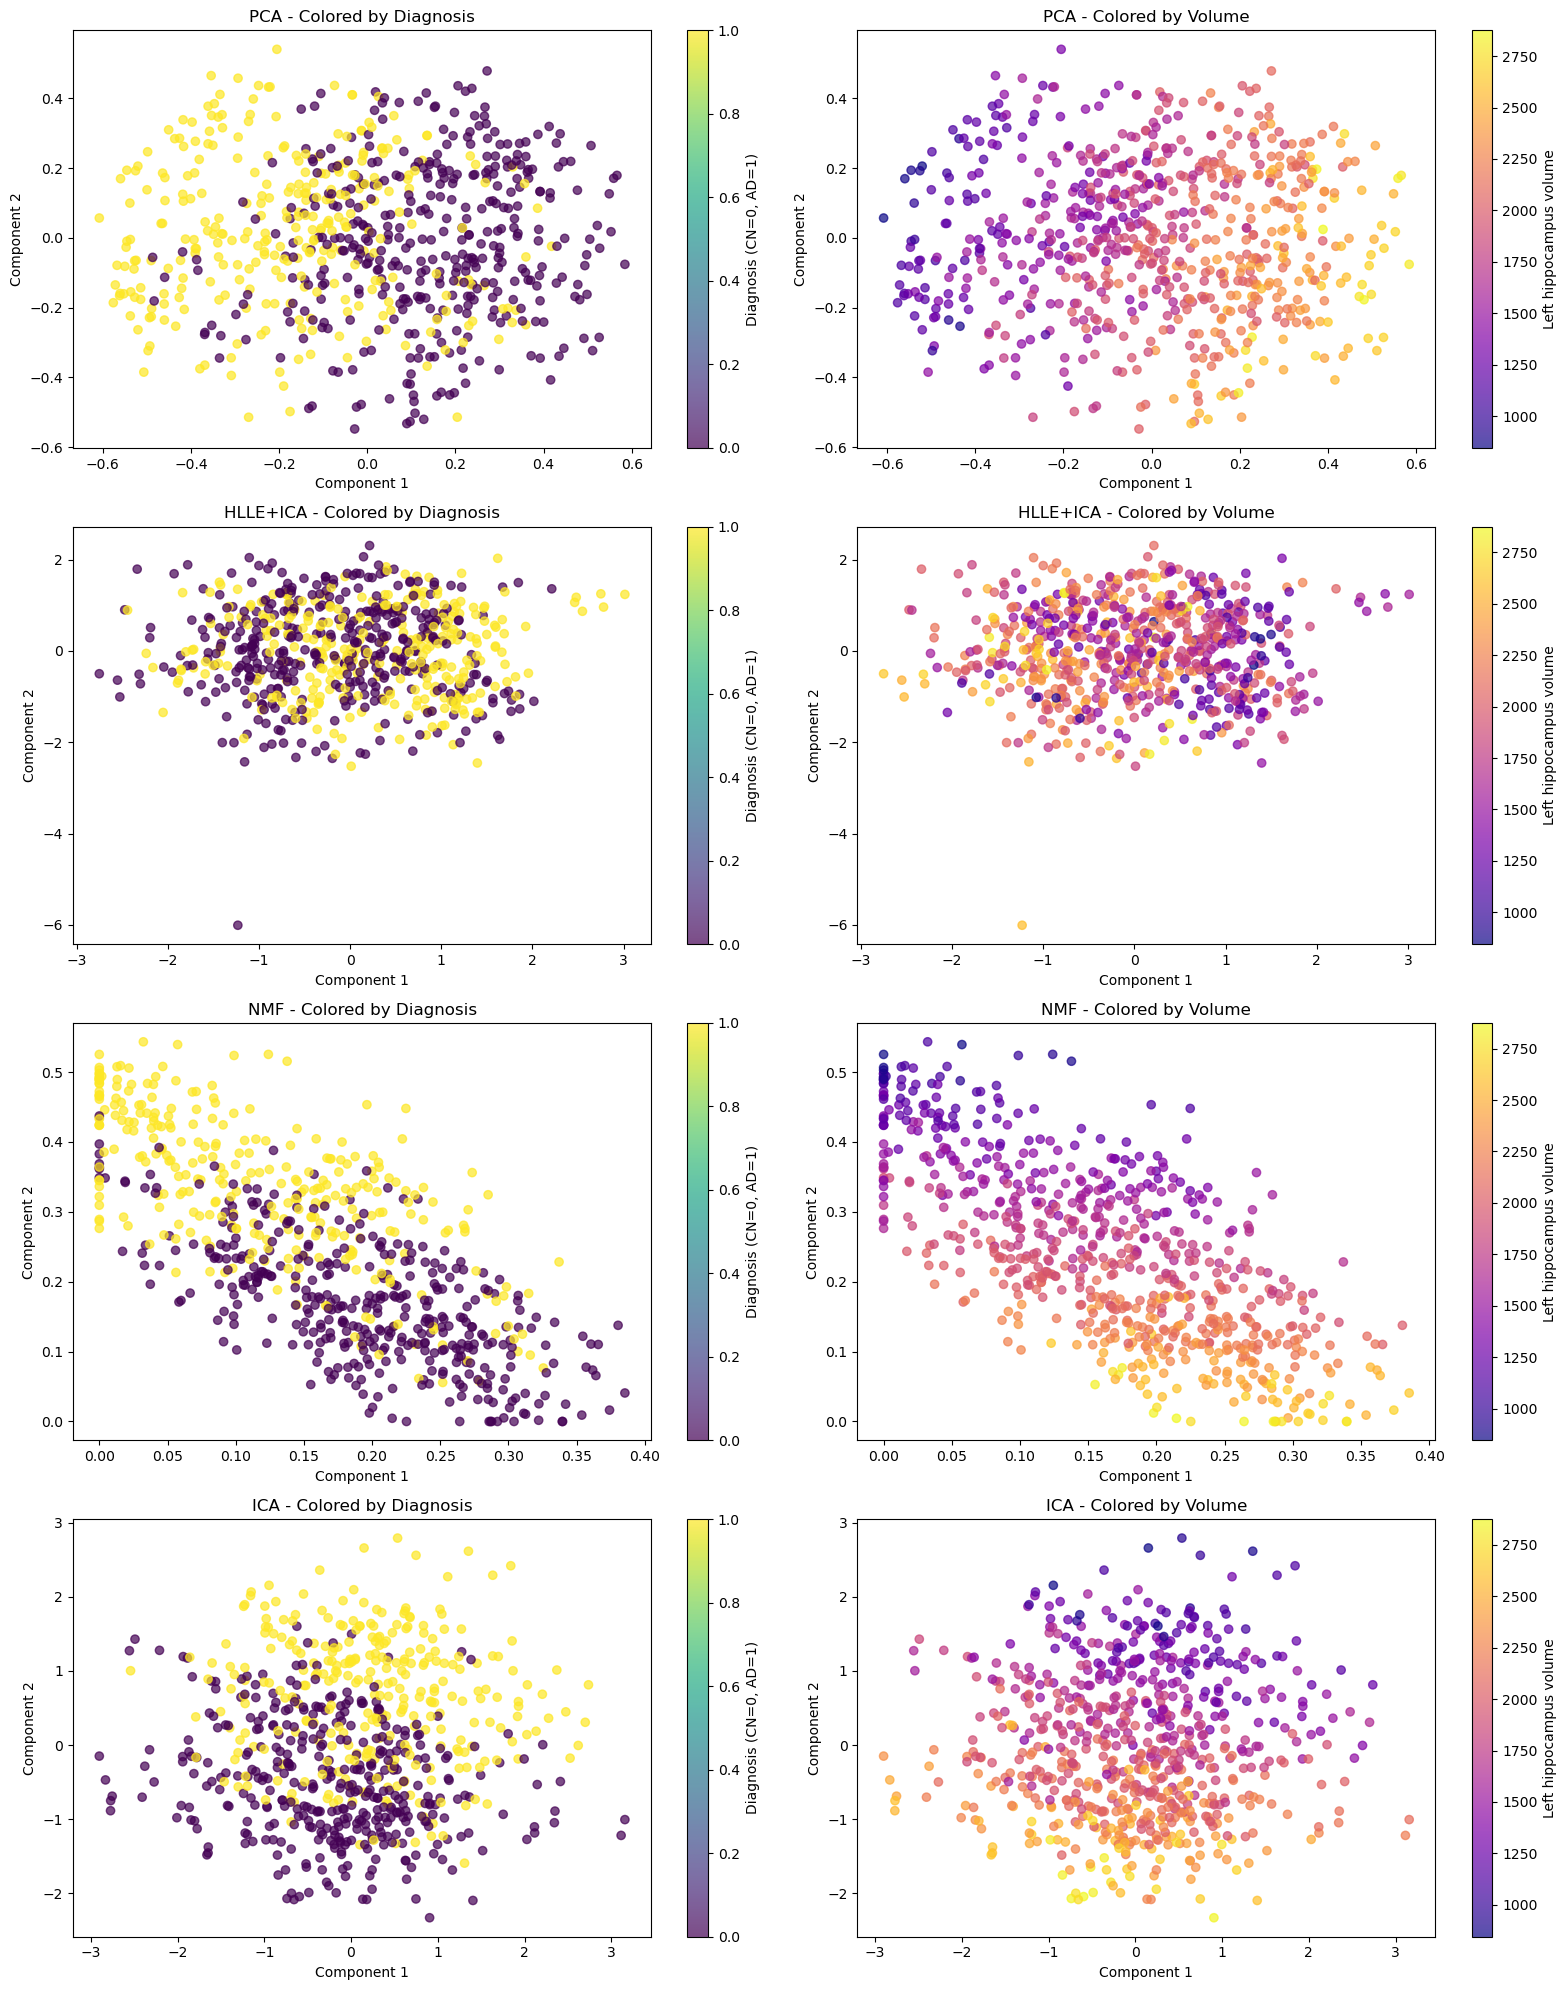

In [22]:
# 4. Visualize results
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

techniques = ['PCA', 'HLLE+ICA', 'NMF', 'ICA']
for i, technique in enumerate(techniques):
    if np.all(results[technique] == 0):
        continue

    scatter = axes[i, 0].scatter(results[technique][:, 0], results[technique][:, 1],
                                c=diagnosis, cmap='viridis', alpha=0.7)
    axes[i, 0].set_title(f'{technique} - Colored by Diagnosis')
    axes[i, 0].set_xlabel('Component 1')
    axes[i, 0].set_ylabel('Component 2')
    plt.colorbar(scatter, ax=axes[i, 0], label='Diagnosis (CN=0, AD=1)')

    mask = np.isfinite(volume)
    scatter = axes[i, 1].scatter(results[technique][mask, 0], results[technique][mask, 1],
                                c=volume[mask], cmap='plasma', alpha=0.7)
    axes[i, 1].set_title(f'{technique} - Colored by Volume')
    axes[i, 1].set_xlabel('Component 1')
    axes[i, 1].set_ylabel('Component 2')
    plt.colorbar(scatter, ax=axes[i, 1], label='Left hippocampus volume')

plt.tight_layout()
plt.show()


In [ ]:
# 5. Correlation Analysis
print('\nCorrelation Analysis:')
for technique in techniques:
    if np.all(results[technique] == 0):
        continue

    print(f'\n{technique} Analysis:')
    num_components = results[technique].shape[1]
    if np.any(diagnosis >= 0):
        mask = diagnosis >= 0
        for comp_idx in range(num_components):
            corr = np.corrcoef(results[technique][mask, comp_idx], diagnosis[mask])[0, 1]
            print(f'Component {comp_idx + 1} correlation with diagnosis: {corr:.4f}')
    if np.any(np.isfinite(age)):
        mask = np.isfinite(age)
        for comp_idx in range(num_components):
            corr = np.corrcoef(results[technique][mask, comp_idx], age[mask])[0, 1]
            print(f'Component {comp_idx + 1} correlation with age: {corr:.4f}')
    if np.any(sex >= 0):
        mask = sex >= 0
        for comp_idx in range(num_components):
            corr = np.corrcoef(results[technique][mask, comp_idx], sex[mask])[0, 1]
            print(f'Component {comp_idx + 1} correlation with sex: {corr:.4f}')
    if np.any(np.isfinite(volume)):
        mask = np.isfinite(volume)
        for comp_idx in range(num_components):
            corr = np.corrcoef(results[technique][mask, comp_idx], volume[mask])[0, 1]
            print(f'Component {comp_idx + 1} correlation with volume: {corr:.4f}')


In [ ]:
# 6. SAP Analysis (Disease + Age)
from sdf_utils import sap as sap_metric

print('SAP Analysis:')

def _mask_codes_factors(codes, factors, mask=None):
    codes = np.asarray(codes)
    factors = np.asarray(factors)
    if factors.ndim == 1:
        factors = factors.reshape(-1, 1)
    if codes.shape[0] != factors.shape[0]:
        print(f'  Skipping: codes/factors row mismatch ({codes.shape[0]} vs {factors.shape[0]})')
        return None, None
    if mask is not None:
        codes = codes[mask]
        factors = factors[mask]
    finite_mask = np.isfinite(factors).all(axis=1) & np.isfinite(codes).all(axis=1)
    codes = codes[finite_mask]
    factors = factors[finite_mask]
    if codes.shape[0] < 4:
        print('  Skipping: not enough valid samples after filtering.')
        return None, None
    return codes, factors


def _sap_disease(codes, diagnosis, nb_bins=10, train_frac=0.8, seed=0, pred_sample_n=5):
    mask = diagnosis >= 0
    codes_m, factors_m = _mask_codes_factors(codes, diagnosis, mask=mask)
    if codes_m is None:
        return

    sap_score = sap_metric.sap(
        factors_m,
        codes_m,
        continuous_factors=False,
        nb_bins=nb_bins,
        regression=False,
    )
    sap_matrix = sap_metric.sap_score_matrix(
        factors_m,
        codes_m,
        continuous_factors=False,
        nb_bins=nb_bins,
        regression=False,
    )
    per_latent = sap_matrix[0] if sap_matrix.shape[0] else np.array([])

    loc_sap, loc_err, loc_pred = sap_metric.sap_binary_classification_locatello(
        factors_m,
        codes_m,
        train_frac=train_frac,
        C=0.01,
        random_state=seed,
        return_predictions=True,
        pred_sample_n=pred_sample_n,
    )

    hold_train_acc, hold_test_acc, hold_pred = sap_metric.sap_classification_holdout_predictions(
        factors_m,
        codes_m,
        continuous_factors=False,
        nb_bins=nb_bins,
        train_frac=train_frac,
        random_state=seed,
        pred_sample_n=pred_sample_n,
    )

    pred_info = sap_metric.sap_classification_predictions(
        factors_m,
        codes_m,
        continuous_factors=False,
        nb_bins=nb_bins,
        pred_sample_n=pred_sample_n,
    )

    holdout_gap = float('nan')
    if hold_test_acc is not None and hold_test_acc.size:
        vals = hold_test_acc[0]
        vals = vals[np.isfinite(vals)]
        if vals.size >= 2:
            vals_sorted = np.sort(vals)
            holdout_gap = float(vals_sorted[-1] - vals_sorted[-2])

    print(f'  Disease SAP: {sap_score:.6f} | Locatello SAP: {loc_sap:.6f} | Kumar holdout gap: {holdout_gap:.6f}')
    print('  Per-latent (disease):')
    for dim in range(codes_m.shape[1]):
        sap_acc = float(per_latent[dim]) if dim < per_latent.size else float('nan')
        hold_acc = (
            float(hold_test_acc[0, dim])
            if hold_test_acc is not None and hold_test_acc.shape[1] > dim
            else float('nan')
        )
        loc_acc = (
            float(1.0 - loc_err[0, dim])
            if loc_err is not None and loc_err.shape[1] > dim and np.isfinite(loc_err[0, dim])
            else float('nan')
        )
        info = pred_info[0][dim] if pred_info else None
        counts = info.get('pred_counts') if info else None
        print(f'    dim {dim:2d} | sap_acc={sap_acc:.4f} | hold_acc={hold_acc:.4f} | loc_acc={loc_acc:.4f} | pred_counts={counts}')


def _sap_age(codes, age, pred_sample_n=5):
    mask = np.isfinite(age)
    codes_m, factors_m = _mask_codes_factors(codes, age, mask=mask)
    if codes_m is None:
        return

    sap_score = sap_metric.sap(
        factors_m,
        codes_m,
        continuous_factors=True,
        regression=True,
    )
    sap_matrix = sap_metric.sap_score_matrix(
        factors_m,
        codes_m,
        continuous_factors=True,
        regression=True,
    )
    per_latent = sap_matrix[0] if sap_matrix.shape[0] else np.array([])
    pred_info = sap_metric.sap_regression_predictions(
        factors_m,
        codes_m,
        pred_sample_n=pred_sample_n,
    )

    print(f'  Age SAP (regression): {sap_score:.6f}')
    print('  Per-latent (age):')
    for dim in range(codes_m.shape[1]):
        sap_r2 = float(per_latent[dim]) if dim < per_latent.size else float('nan')
        info = pred_info[0][dim] if pred_info else None
        pred_mean = info.get('pred_mean') if info else None
        pred_std = info.get('pred_std') if info else None
        print(f'    dim {dim:2d} | sap_r2={sap_r2:.4f} | pred_mean={pred_mean:.4f} | pred_std={pred_std:.4f}')


for technique in techniques:
    if np.all(results[technique] == 0):
        continue
    print(f'{technique} SAP:')
    codes = results[technique]
    _sap_disease(codes, diagnosis)
    _sap_age(codes, age)



In [ ]:
# 7. Reconstruction Error (PCA / ICA)
print('Reconstruction Error:')

if 'X' not in globals():
    raise RuntimeError('X not found. Run the latent loading cell first.')


def _mse(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    if a.shape != b.shape:
        print(f'  Shape mismatch: {a.shape} vs {b.shape}')
        return float('nan')
    mask = np.isfinite(a) & np.isfinite(b)
    if not np.any(mask):
        return float('nan')
    return float(np.mean((a[mask] - b[mask]) ** 2))

# PCA reconstruction
if 'pca' in globals() and 'results' in globals() and results.get('PCA') is not None:
    try:
        X_pca_rec = pca.inverse_transform(results['PCA'])
        mse_pca = _mse(X, X_pca_rec)
        print(f'  PCA reconstruction MSE: {mse_pca:.6f}')
    except Exception as e:
        print(f'  PCA reconstruction failed: {e}')
else:
    print('  PCA reconstruction skipped (missing pca/results).')

# ICA reconstruction
if 'ica' in globals() and 'results' in globals() and results.get('ICA') is not None:
    try:
        X_ica_rec = ica.inverse_transform(results['ICA'])
        mse_ica = _mse(X, X_ica_rec)
        print(f'  ICA reconstruction MSE: {mse_ica:.6f}')
    except Exception as e:
        print(f'  ICA reconstruction failed: {e}')
else:
    print('  ICA reconstruction skipped (missing ica/results).')

In [ ]:
# 8. Reconstruct 100 shapes + average Chamfer distance (PCA/ICA recon latents)
from deep_sdf import mesh as ds_mesh
from deep_sdf import metrics as ds_metrics

print('\nReconstructing 100 shapes and computing average Chamfer distance...')

if 'experiment_dir' not in globals():
    raise RuntimeError('experiment_dir not found. Run the latent loading cell first.')
if 'checkpoint' not in globals():
    checkpoint = 'latest'
if 'latent_vectors' not in globals():
    raise RuntimeError('latent_vectors not found. Run the latent loading cell first.')
if 'valid_filenames' not in globals():
    raise RuntimeError('valid_filenames not found. Run the split/label loading cell first.')
if 'mesh_root' not in globals():
    raise RuntimeError('mesh_root not found. Run the split/label loading cell first.')
if 'X' not in globals():
    raise RuntimeError('X not found. Run the latent loading cell first.')

# Config (reduced for GPU memory)
num_shapes = 20
grid_res = 64
max_batch = 2 ** 16
num_mesh_samples = 10000
use_cpu = False  # set True to force CPU if GPU is busy

# Choose latent source: 'ORIG', 'PCA', or 'ICA'
latent_source = 'PCA'

latent_source = latent_source.upper()
if latent_source not in ('ORIG', 'PCA', 'ICA'):
    raise ValueError(f'Unknown latent_source: {latent_source}')

# Device
import torch

device = torch.device('cpu')
if torch.cuda.is_available() and not use_cpu:
    device = torch.device('cuda')

# Load decoder (handle DataParallel vs non-DataParallel checkpoints)
specs = ws.load_experiment_specifications(experiment_dir)
ckpt_path = os.path.join(experiment_dir, ws.model_params_subdir, checkpoint + '.pth')
if not os.path.isfile(ckpt_path):
    raise RuntimeError(f'Checkpoint not found: {ckpt_path}')
ckpt = torch.load(ckpt_path, map_location='cpu')
state_dict = ckpt.get('model_state_dict', ckpt)
# Strip DataParallel prefix if present
if all(k.startswith('module.') for k in state_dict.keys()):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

decoder = ws.build_decoder(experiment_dir, specs)
missing, unexpected = decoder.load_state_dict(state_dict, strict=False)
if missing or unexpected:
    print(f'  load_state_dict missing={len(missing)} unexpected={len(unexpected)}')
decoder = decoder.to(device)
decoder.eval()

# Build reconstructed latents (if requested)
recon_latents = None
if latent_source == 'PCA':
    if 'pca' not in globals() or 'results' not in globals() or results.get('PCA') is None:
        raise RuntimeError('PCA results not found. Run the PCA cell first.')
    recon_latents = pca.inverse_transform(results['PCA'])
elif latent_source == 'ICA':
    if 'ica' not in globals() or 'results' not in globals() or results.get('ICA') is None:
        raise RuntimeError('ICA results not found. Run the ICA cell first.')
    recon_latents = ica.inverse_transform(results['ICA'])

# Determine usable count
n_total = min(len(valid_filenames), X.shape[0])
if recon_latents is not None:
    n_total = min(n_total, recon_latents.shape[0])
if n_total == 0:
    raise RuntimeError('No samples available to reconstruct.')

num_shapes = min(num_shapes, n_total)
indices = list(range(num_shapes))

# Helper to fetch latent

def _get_latent(idx):
    if recon_latents is not None:
        z = torch.tensor(recon_latents[idx:idx+1], dtype=torch.float32)
    elif torch.is_tensor(latent_vectors):
        z = latent_vectors[idx:idx+1]
    elif isinstance(latent_vectors, list):
        z = latent_vectors[idx]
        if torch.is_tensor(z) and z.dim() == 1:
            z = z.unsqueeze(0)
    else:
        z = torch.tensor(X[idx:idx+1], dtype=torch.float32)
    return z.to(device)

# Helper to resolve GT mesh path

def _resolve_mesh_path(base_name):
    candidates = [
        os.path.join(mesh_root, base_name + '.obj'),
        os.path.join(mesh_root, base_name + '.ply'),
    ]
    for c in candidates:
        if os.path.isfile(c):
            return c
    # fallback: any file with base name
    matches = [p for p in os.listdir(mesh_root) if os.path.splitext(p)[0] == base_name]
    if matches:
        return os.path.join(mesh_root, matches[0])
    return None

chamfers = []
missing = 0
failed = 0

for idx in indices:
    filename = valid_filenames[idx]
    base_name = os.path.splitext(os.path.basename(filename))[0]
    gt_path = _resolve_mesh_path(base_name)
    if gt_path is None:
        missing += 1
        continue

    try:
        z = _get_latent(idx)
        with torch.no_grad():
            gen_mesh = ds_mesh.create_mesh(
                decoder,
                z,
                N=grid_res,
                max_batch=max_batch,
                return_trimesh=True,
            )
        if gen_mesh is None:
            failed += 1
            continue
        cd, _ = ds_metrics.compute_metric(
            gt_mesh=gt_path,
            gen_mesh=gen_mesh,
            num_mesh_samples=num_mesh_samples,
            metric='chamfer',
        )
        chamfers.append(cd)
        del gen_mesh
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    except Exception as e:
        print(f'  Failed at idx {idx} ({base_name}): {e}')
        failed += 1
        if device.type == 'cuda':
            torch.cuda.empty_cache()

if chamfers:
    mean_cd = float(np.mean(chamfers))
    print(f'Average Chamfer distance over {len(chamfers)} shapes: {mean_cd:.6f}')
else:
    print('No Chamfer distances computed.')

if missing or failed:
    print(f'Missing meshes: {missing} | Failed reconstructions: {failed}')



In [ ]:
from scipy.stats import kurtosis, skew
from sklearn.metrics import normalized_mutual_info_score

def evaluate_ica_quality(components):
    """Evaluate ICA component quality using statistical measures"""
    metrics = {}
    
    for i in range(components.shape[1]):
        comp = components[:, i]
        
        # Kurtosis (departure from Gaussianity)
        kurt = kurtosis(comp)
        
        # Skewness (asymmetry)
        skewness = skew(comp)
        
        # Negentropy approximation (measure of non-Gaussianity)
        # Using tanh approximation
        negentropy = np.mean(np.tanh(comp)**2) - (np.mean(np.tanh(comp)))**2
        
        metrics[f'component_{i}'] = {
            'kurtosis': kurt,
            'skewness': skewness,
            'negentropy': negentropy,
            'variance': np.var(comp)
        }
    
    return metrics

# Usage
for technique in techniques:
    if technique in results and not np.all(results[technique] == 0):
        quality = evaluate_ica_quality(results[technique])
        print(f"\n{technique} Quality Metrics:")
        for comp, metrics in quality.items():
            print(f"{comp}: Kurt={metrics['kurtosis']:.3f}, "
                  f"Skew={metrics['skewness']:.3f}, "
                  f"Negent={metrics['negentropy']:.3f}")

Projecting individual latent vectors onto learned components...
Projection shapes:
PCA: (696, 4)
ICA: (696, 4)
HLLE+ICA: (696, 2)


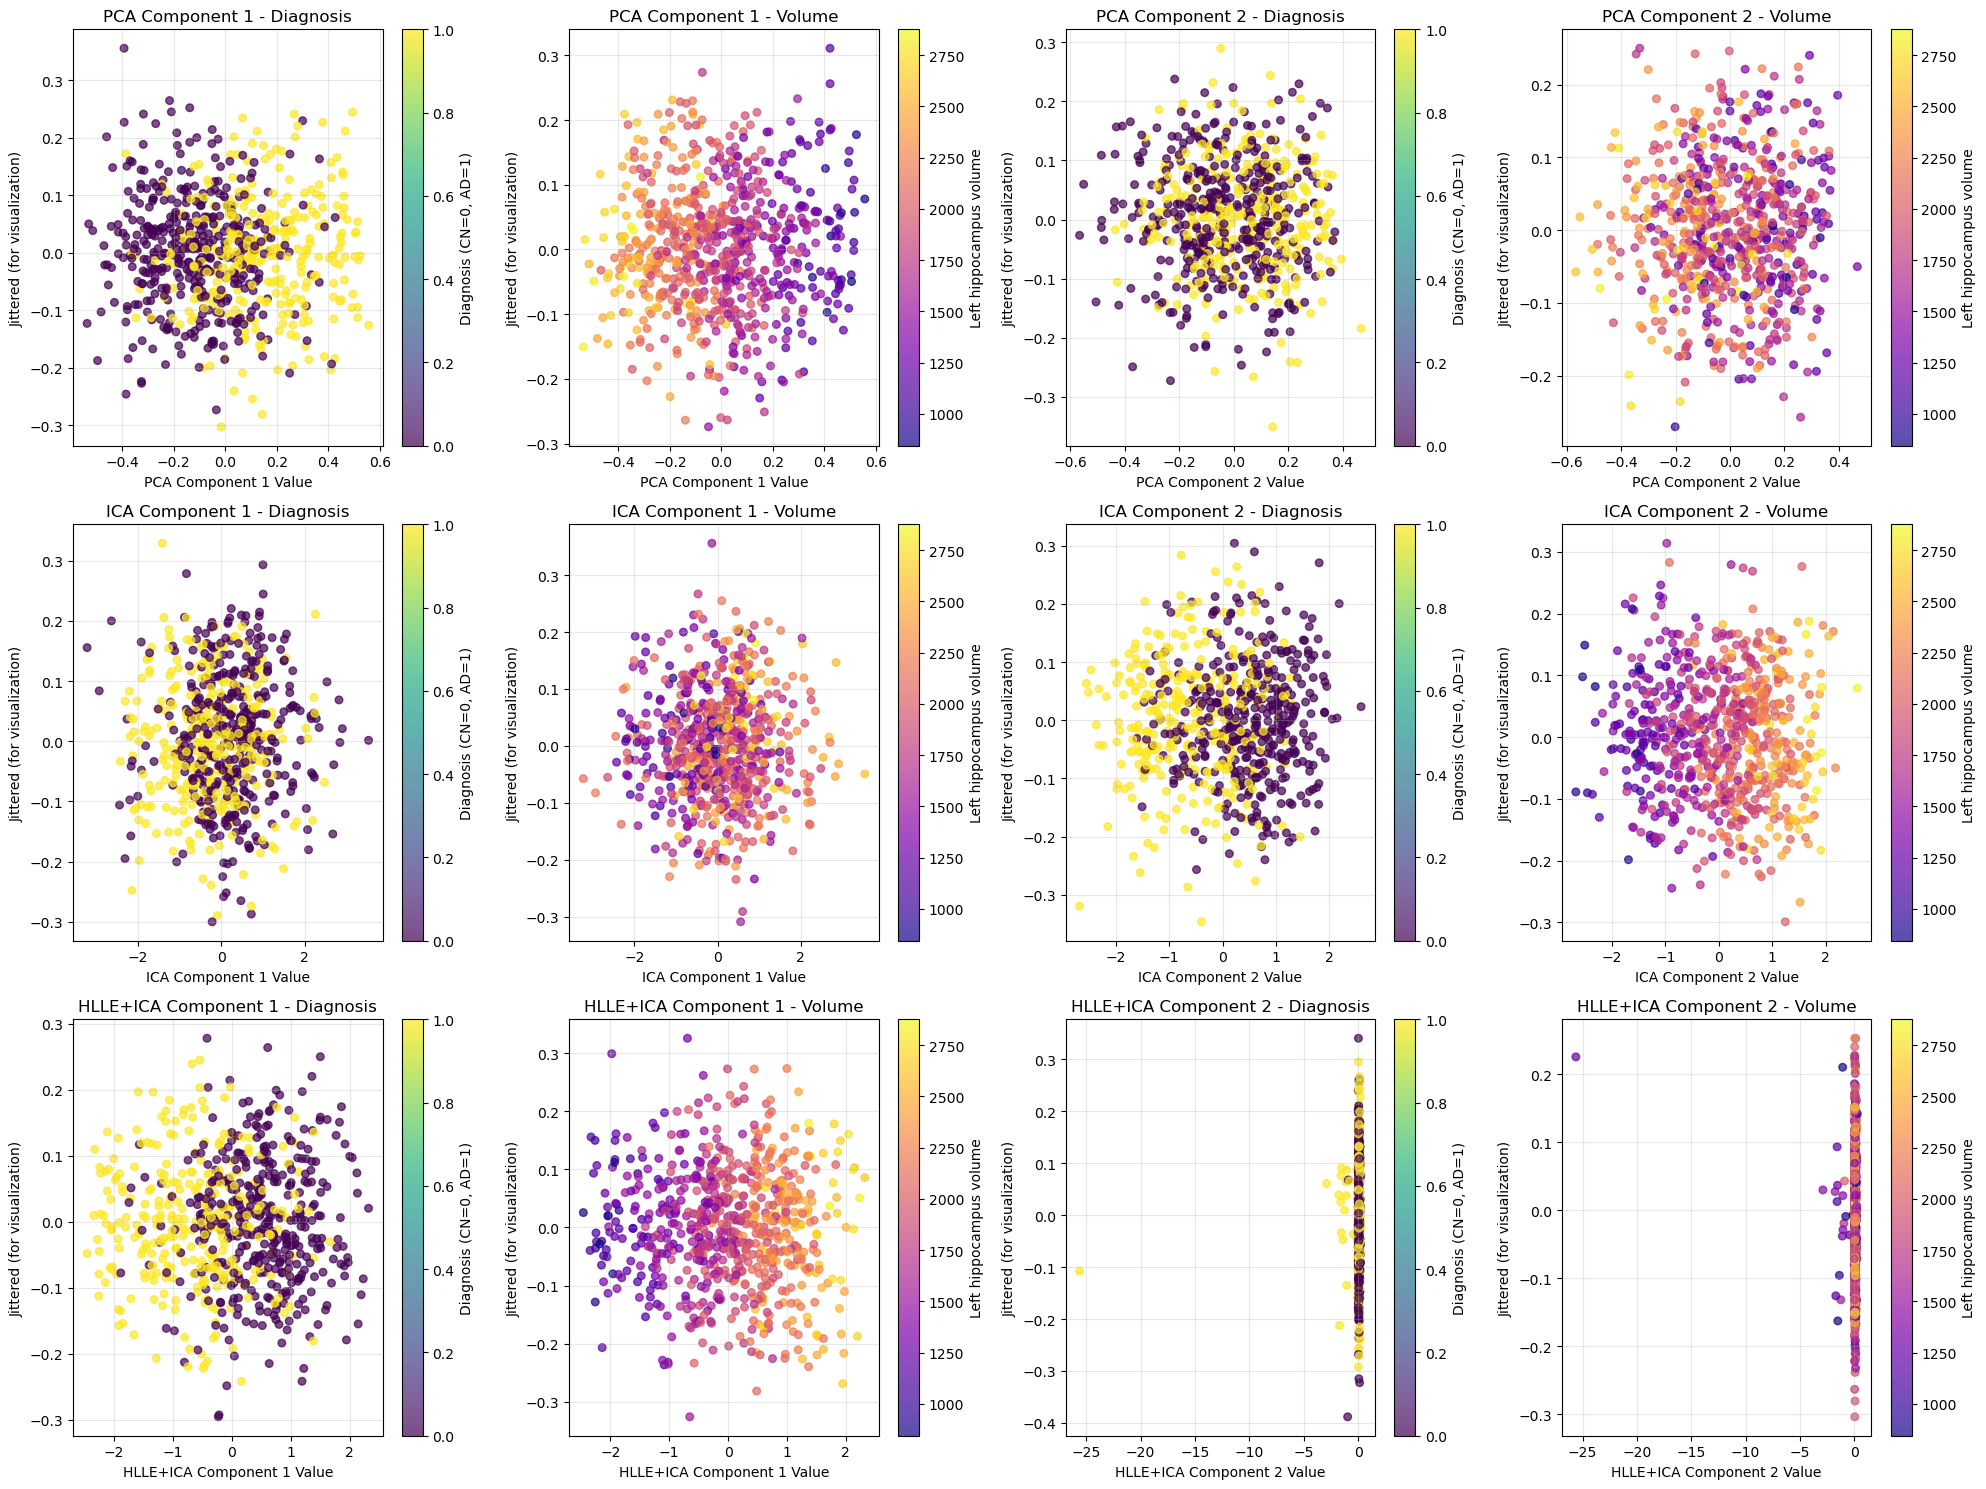

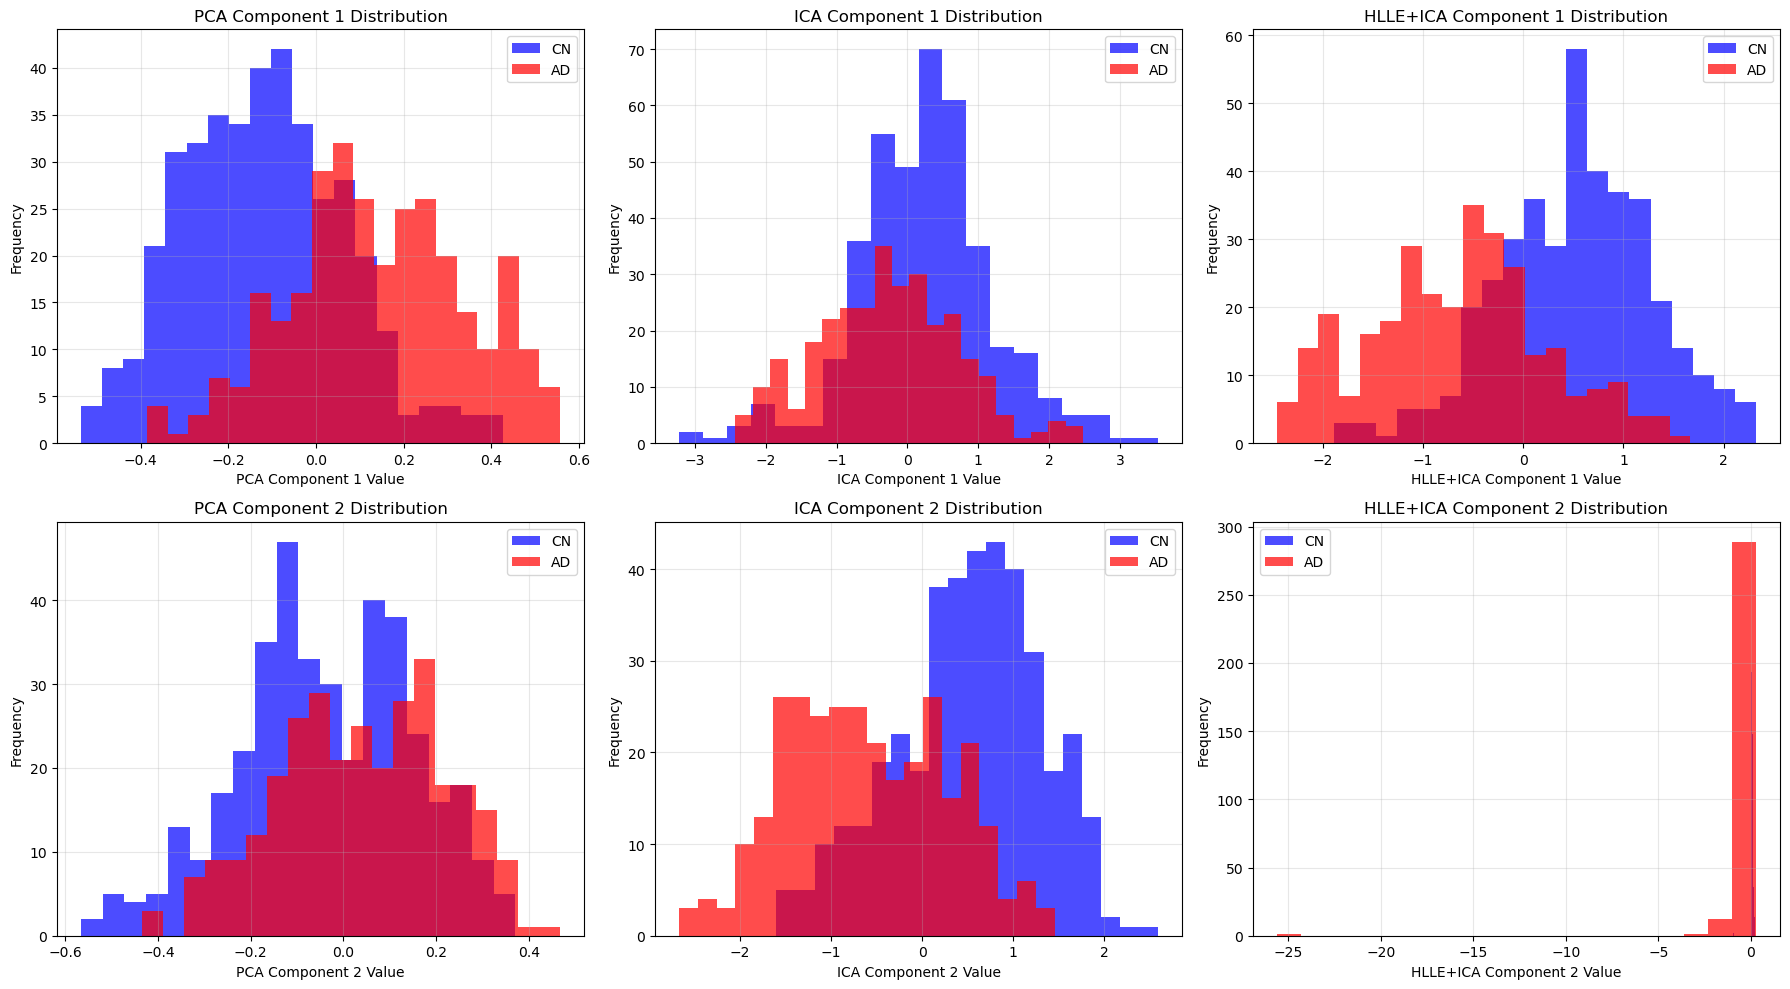

In [35]:
# 9. Project individual latent vectors onto learned components
print('Projecting individual latent vectors onto learned components...')

X_16d = latent_vectors.cpu().numpy()

individual_projections = {}

pca_components = pca.components_
pca_projections = X_16d @ pca_components.T
individual_projections['PCA'] = pca_projections

ica_components = ica.components_
ica_projections = X_16d @ ica_components.T
individual_projections['ICA'] = ica_projections

if best_Y_hlle_ica is not None:
    best_n_neighbors = best_params[0]
    hlle_for_projection = LocallyLinearEmbedding(n_neighbors=best_n_neighbors,
                                                 n_components=2,
                                                 method='hessian',
                                                 eigen_solver='dense')
    hlle_for_projection.fit(X)
    hlle_transformed = hlle_for_projection.transform(X_16d)
    ica_after_hlle = FastICA(n_components=2, random_state=42)
    hlle_train_transformed = hlle_for_projection.transform(X)
    ica_after_hlle.fit(hlle_train_transformed)
    hlle_ica_projections = ica_after_hlle.transform(hlle_transformed)
    individual_projections['HLLE+ICA'] = hlle_ica_projections
else:
    individual_projections['HLLE+ICA'] = None

print('Projection shapes:')
for method, proj in individual_projections.items():
    if proj is not None:
        print(f'{method}: {proj.shape}')

# 10. Visualize projections of first two components against labels
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

methods = ['PCA', 'ICA', 'HLLE+ICA']
for i, method in enumerate(methods):
    if individual_projections[method] is None:
        for j in range(4):
            axes[i, j].text(0.5, 0.5, f'{method}\nFailed', ha='center', va='center')
        continue

    projections = individual_projections[method]

    jittered_y1 = np.random.normal(0, 0.1, len(projections))
    scatter1 = axes[i, 0].scatter(projections[:, 0], jittered_y1, c=diagnosis,
                                 cmap='viridis', alpha=0.7, s=30)
    axes[i, 0].set_xlabel(f'{method} Component 1 Value')
    axes[i, 0].set_ylabel('Jittered (for visualization)')
    axes[i, 0].set_title(f'{method} Component 1 - Diagnosis')
    axes[i, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[i, 0], label='Diagnosis (CN=0, AD=1)')

    vol_mask = np.isfinite(volume)
    jittered_y2 = np.random.normal(0, 0.1, np.sum(vol_mask))
    scatter2 = axes[i, 1].scatter(projections[vol_mask, 0], jittered_y2, c=volume[vol_mask],
                                 cmap='plasma', alpha=0.7, s=30)
    axes[i, 1].set_xlabel(f'{method} Component 1 Value')
    axes[i, 1].set_ylabel('Jittered (for visualization)')
    axes[i, 1].set_title(f'{method} Component 1 - Volume')
    axes[i, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[i, 1], label='Left hippocampus volume')

    if projections.shape[1] > 1:
        jittered_y3 = np.random.normal(0, 0.1, len(projections))
        scatter3 = axes[i, 2].scatter(projections[:, 1], jittered_y3, c=diagnosis,
                                     cmap='viridis', alpha=0.7, s=30)
        axes[i, 2].set_xlabel(f'{method} Component 2 Value')
        axes[i, 2].set_ylabel('Jittered (for visualization)')
        axes[i, 2].set_title(f'{method} Component 2 - Diagnosis')
        axes[i, 2].grid(True, alpha=0.3)
        plt.colorbar(scatter3, ax=axes[i, 2], label='Diagnosis (CN=0, AD=1)')

        jittered_y4 = np.random.normal(0, 0.1, np.sum(vol_mask))
        scatter4 = axes[i, 3].scatter(projections[vol_mask, 1], jittered_y4, c=volume[vol_mask],
                                     cmap='plasma', alpha=0.7, s=30)
        axes[i, 3].set_xlabel(f'{method} Component 2 Value')
        axes[i, 3].set_ylabel('Jittered (for visualization)')
        axes[i, 3].set_title(f'{method} Component 2 - Volume')
        axes[i, 3].grid(True, alpha=0.3)
        plt.colorbar(scatter4, ax=axes[i, 3], label='Left hippocampus volume')
    else:
        axes[i, 2].text(0.5, 0.5, 'Only 1\nComponent', ha='center', va='center')
        axes[i, 3].text(0.5, 0.5, 'Only 1\nComponent', ha='center', va='center')

plt.tight_layout()
plt.savefig('component_projections_vs_labels_both_components.png', dpi=300, bbox_inches='tight')
plt.show()

# 13. Enhanced histogram visualization - both components
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, method in enumerate(methods):
    if individual_projections[method] is None:
        axes[0, i].text(0.5, 0.5, f'{method}\nFailed', ha='center', va='center')
        axes[1, i].text(0.5, 0.5, f'{method}\nFailed', ha='center', va='center')
        continue

    projections = individual_projections[method]
    cn_mask = diagnosis == 0
    ad_mask = diagnosis == 1

    first_component = projections[:, 0]
    axes[0, i].hist(first_component[cn_mask], alpha=0.7, label='CN', bins=20, color='blue')
    axes[0, i].hist(first_component[ad_mask], alpha=0.7, label='AD', bins=20, color='red')
    axes[0, i].set_xlabel(f'{method} Component 1 Value')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_title(f'{method} Component 1 Distribution')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

    if projections.shape[1] > 1:
        second_component = projections[:, 1]
        axes[1, i].hist(second_component[cn_mask], alpha=0.7, label='CN', bins=20, color='blue')
        axes[1, i].hist(second_component[ad_mask], alpha=0.7, label='AD', bins=20, color='red')
        axes[1, i].set_xlabel(f'{method} Component 2 Value')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_title(f'{method} Component 2 Distribution')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
    else:
        axes[1, i].text(0.5, 0.5, 'Only 1\nComponent', ha='center', va='center')

plt.tight_layout()
plt.savefig('component_distributions_both_components.png', dpi=300, bbox_inches='tight')
plt.show()


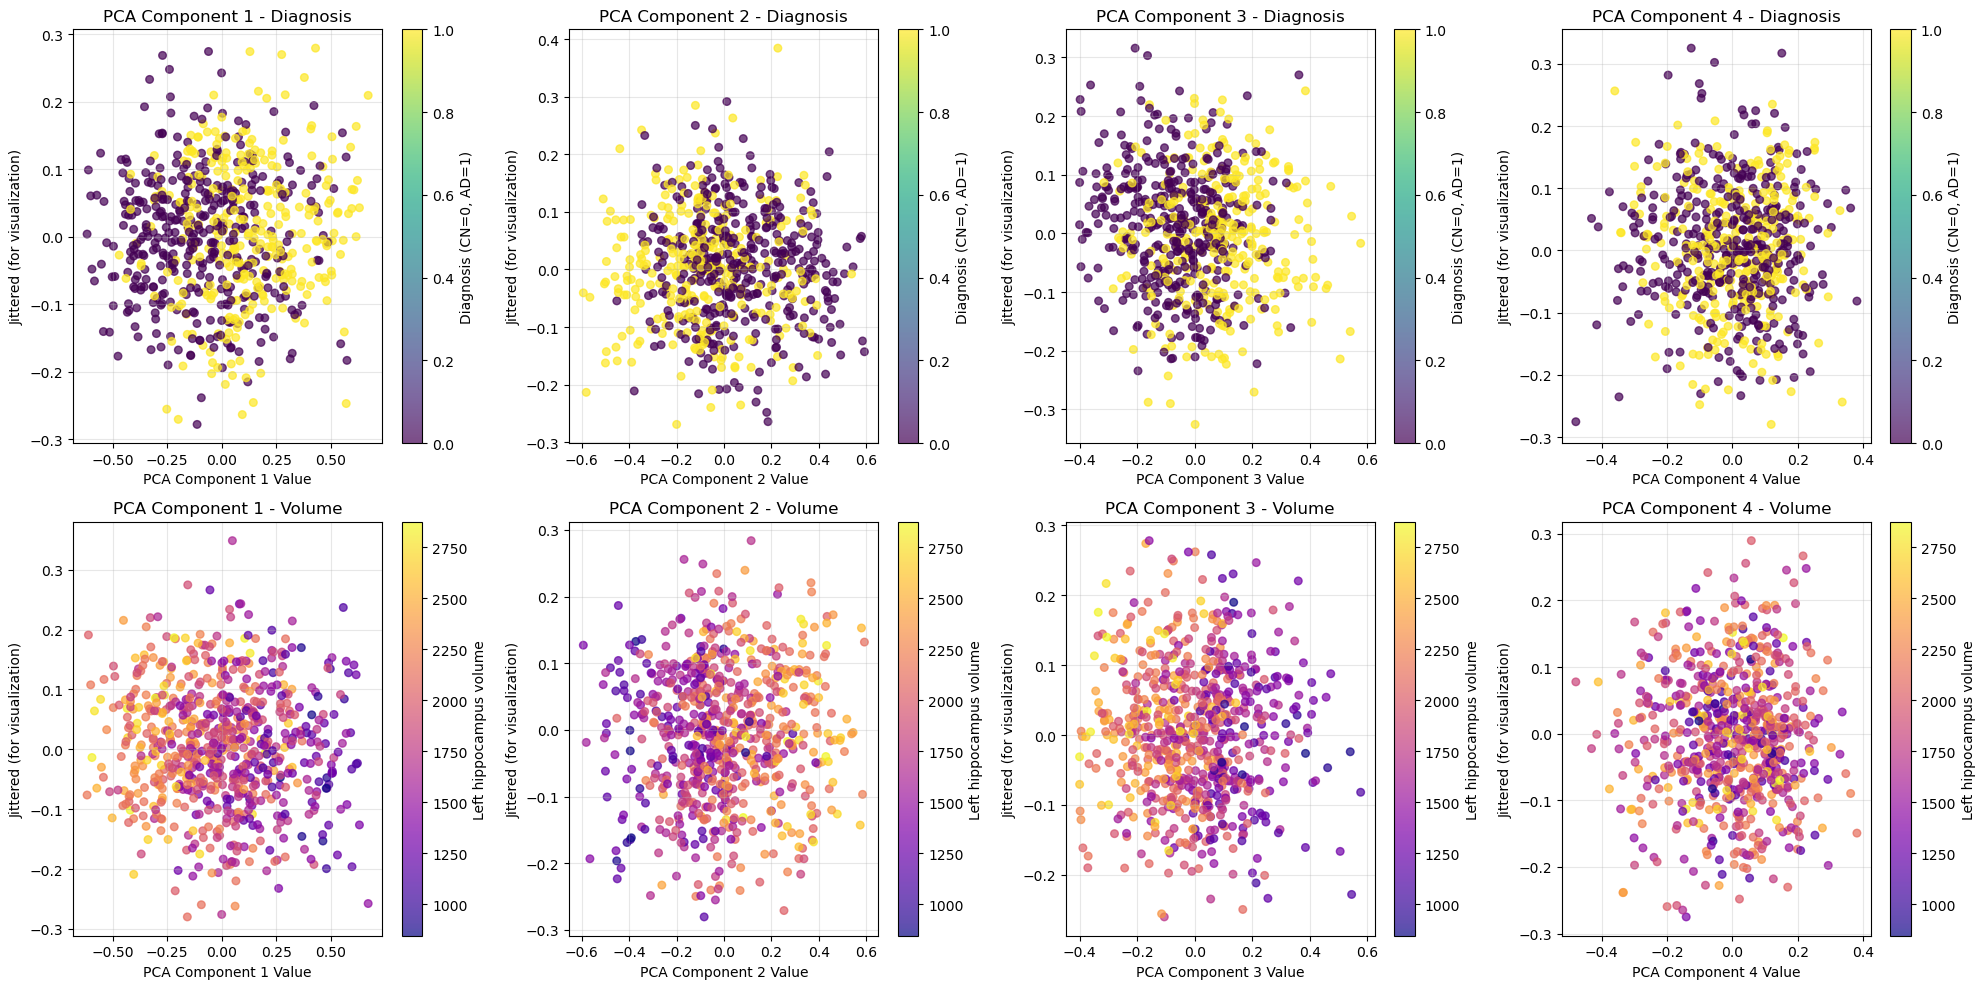

In [86]:
# Plot all 4 PCA components for diagnosis and volume
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

pca_results = results['PCA']

for i in range(4):
    jittered_y = np.random.normal(0, 0.1, len(pca_results))
    scatter = axes[0, i].scatter(pca_results[:, i], jittered_y, c=diagnosis,
                                cmap='viridis', alpha=0.7, s=30)
    axes[0, i].set_xlabel(f'PCA Component {i+1} Value')
    axes[0, i].set_ylabel('Jittered (for visualization)')
    axes[0, i].set_title(f'PCA Component {i+1} - Diagnosis')
    axes[0, i].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, i], label='Diagnosis (CN=0, AD=1)')

for i in range(4):
    mask = np.isfinite(volume)
    jittered_y = np.random.normal(0, 0.1, np.sum(mask))
    scatter = axes[1, i].scatter(pca_results[mask, i], jittered_y, c=volume[mask],
                                cmap='plasma', alpha=0.7, s=30)
    axes[1, i].set_xlabel(f'PCA Component {i+1} Value')
    axes[1, i].set_ylabel('Jittered (for visualization)')
    axes[1, i].set_title(f'PCA Component {i+1} - Volume')
    axes[1, i].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, i], label='Left hippocampus volume')

plt.tight_layout()
plt.show()


In [ ]:
# Test if volume information is distributed across all dimensions
print('\nAnalyzing volume encoding across all latent dimensions:')

latent_volume_correlations = []
mask = np.isfinite(volume)
for dim in range(X.shape[1]):
    if np.any(mask):
        corr = np.corrcoef(X[mask, dim], volume[mask])[0, 1]
    else:
        corr = float('nan')
    latent_volume_correlations.append(corr)
    print(f'Latent dim {dim+1}: volume correlation = {corr:.4f}')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

if np.any(mask):
    lr = LinearRegression()
    lr.fit(X[mask], volume[mask])
    predicted_volumes = lr.predict(X[mask])
    r2 = r2_score(volume[mask], predicted_volumes)
    quality = 'well' if r2 > 0.7 else 'poorly'
    print(f'\nLinear regression R² for predicting volume: {r2:.4f}')
    print(f'This suggests volume information is {quality} encoded in the full latent space')
else:
    print('No finite volume values for linear regression.')

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(latent_volume_correlations) + 1), latent_volume_correlations)
plt.xlabel('Latent Dimension')
plt.ylabel('Correlation with Volume')
plt.title('Correlation of Latent Dimensions with Volume')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Add this cell to your notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns

# Unsupervised Clustering Analysis
print("=== UNSUPERVISED CLUSTERING ANALYSIS ===")

# Use your original 16D latent vectors
X_clustering = X.copy()  # Your original 16D latent vectors

# Standardize the data for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Dictionary to store clustering results
clustering_results = {}
cluster_metrics = {}

# 1. K-Means Clustering with different numbers of clusters
print("\n1. K-Means Clustering:")
k_range = range(2, 11)  # Try 2 to 10 clusters
kmeans_scores = {'silhouette': [], 'calinski': [], 'davies_bouldin': []}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate clustering metrics
    sil_score = silhouette_score(X_scaled, cluster_labels)
    cal_score = calinski_harabasz_score(X_scaled, cluster_labels)
    db_score = davies_bouldin_score(X_scaled, cluster_labels)
    
    kmeans_scores['silhouette'].append(sil_score)
    kmeans_scores['calinski'].append(cal_score)
    kmeans_scores['davies_bouldin'].append(db_score)
    
    print(f"K={k}: Silhouette={sil_score:.3f}, Calinski-Harabasz={cal_score:.1f}, Davies-Bouldin={db_score:.3f}")
    
    if k == 3:  # Store 3-cluster result as example
        clustering_results['KMeans_3'] = cluster_labels
        cluster_metrics['KMeans_3'] = {'silhouette': sil_score, 'calinski': cal_score, 'davies_bouldin': db_score}

# Find optimal K for K-means
best_k_sil = k_range[np.argmax(kmeans_scores['silhouette'])]
best_k_cal = k_range[np.argmax(kmeans_scores['calinski'])]
best_k_db = k_range[np.argmin(kmeans_scores['davies_bouldin'])]

print(f"\nOptimal K by Silhouette: {best_k_sil}")
print(f"Optimal K by Calinski-Harabasz: {best_k_cal}")
print(f"Optimal K by Davies-Bouldin: {best_k_db}")

# Run K-means with the best K (by silhouette score)
best_kmeans = KMeans(n_clusters=best_k_sil, random_state=42, n_init=10)
best_kmeans_labels = best_kmeans.fit_predict(X_scaled)
clustering_results['KMeans_Best'] = best_kmeans_labels

In [ ]:
# 2. Gaussian Mixture Model
print("\n2. Gaussian Mixture Model:")
gmm_scores = {'silhouette': [], 'aic': [], 'bic': []}

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    cluster_labels = gmm.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, cluster_labels)
    aic_score = gmm.aic(X_scaled)
    bic_score = gmm.bic(X_scaled)
    
    gmm_scores['silhouette'].append(sil_score)
    gmm_scores['aic'].append(aic_score)
    gmm_scores['bic'].append(bic_score)
    
    print(f"K={k}: Silhouette={sil_score:.3f}, AIC={aic_score:.1f}, BIC={bic_score:.1f}")

# Find optimal K for GMM
best_k_gmm = k_range[np.argmax(gmm_scores['silhouette'])]
best_gmm = GaussianMixture(n_components=best_k_gmm, random_state=32)
best_gmm_labels = best_gmm.fit_predict(X_scaled)
clustering_results['GMM_Best'] = best_gmm_labels

# 3. DBSCAN Clustering
print("\n3. DBSCAN Clustering:")
# Try different eps values
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    cluster_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    if n_clusters > 1:  # Only calculate if we have valid clusters
        sil_score = silhouette_score(X_scaled, cluster_labels)
        dbscan_results.append((eps, n_clusters, n_noise, sil_score))
        print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points, Silhouette={sil_score:.3f}")
    else:
        print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points (invalid)")

# Select best DBSCAN result
if dbscan_results:
    best_dbscan = max(dbscan_results, key=lambda x: x[3])  # Best by silhouette score
    best_eps = best_dbscan[0]
    
    dbscan_final = DBSCAN(eps=best_eps, min_samples=5)
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
    clustering_results['DBSCAN_Best'] = dbscan_labels
    print(f"Best DBSCAN: eps={best_eps}, silhouette={best_dbscan[3]:.3f}")

In [ ]:
# 4. Hierarchical Clustering
print("\n4. Hierarchical Clustering:")
hier_linkages = ['ward', 'complete', 'average']
hier_results = {}

for linkage in hier_linkages:
    for k in [2, 3, 4, 5]:
        hierarchical = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        cluster_labels = hierarchical.fit_predict(X_scaled)
        
        sil_score = silhouette_score(X_scaled, cluster_labels)
        hier_results[f'{linkage}_{k}'] = (cluster_labels, sil_score)
        print(f"Linkage={linkage}, K={k}: Silhouette={sil_score:.3f}")

# Find best hierarchical clustering
best_hier = max(hier_results.items(), key=lambda x: x[1][1])
clustering_results['Hierarchical_Best'] = best_hier[1][0]

# 5. Spectral Clustering
print("\n5. Spectral Clustering:")
spectral_results = {}

for k in [2, 3, 4, 5]:
    spectral = SpectralClustering(n_clusters=k, random_state=42)
    cluster_labels = spectral.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, cluster_labels)
    spectral_results[k] = (cluster_labels, sil_score)
    print(f"K={k}: Silhouette={sil_score:.3f}")

# Find best spectral clustering
best_spectral = max(spectral_results.items(), key=lambda x: x[1][1])
clustering_results['Spectral_Best'] = best_spectral[1][0]


6. Visualization of Clustering Results:
UMAP failed (check_array() got an unexpected keyword argument 'ensure_all_finite'); using t-SNE for visualization


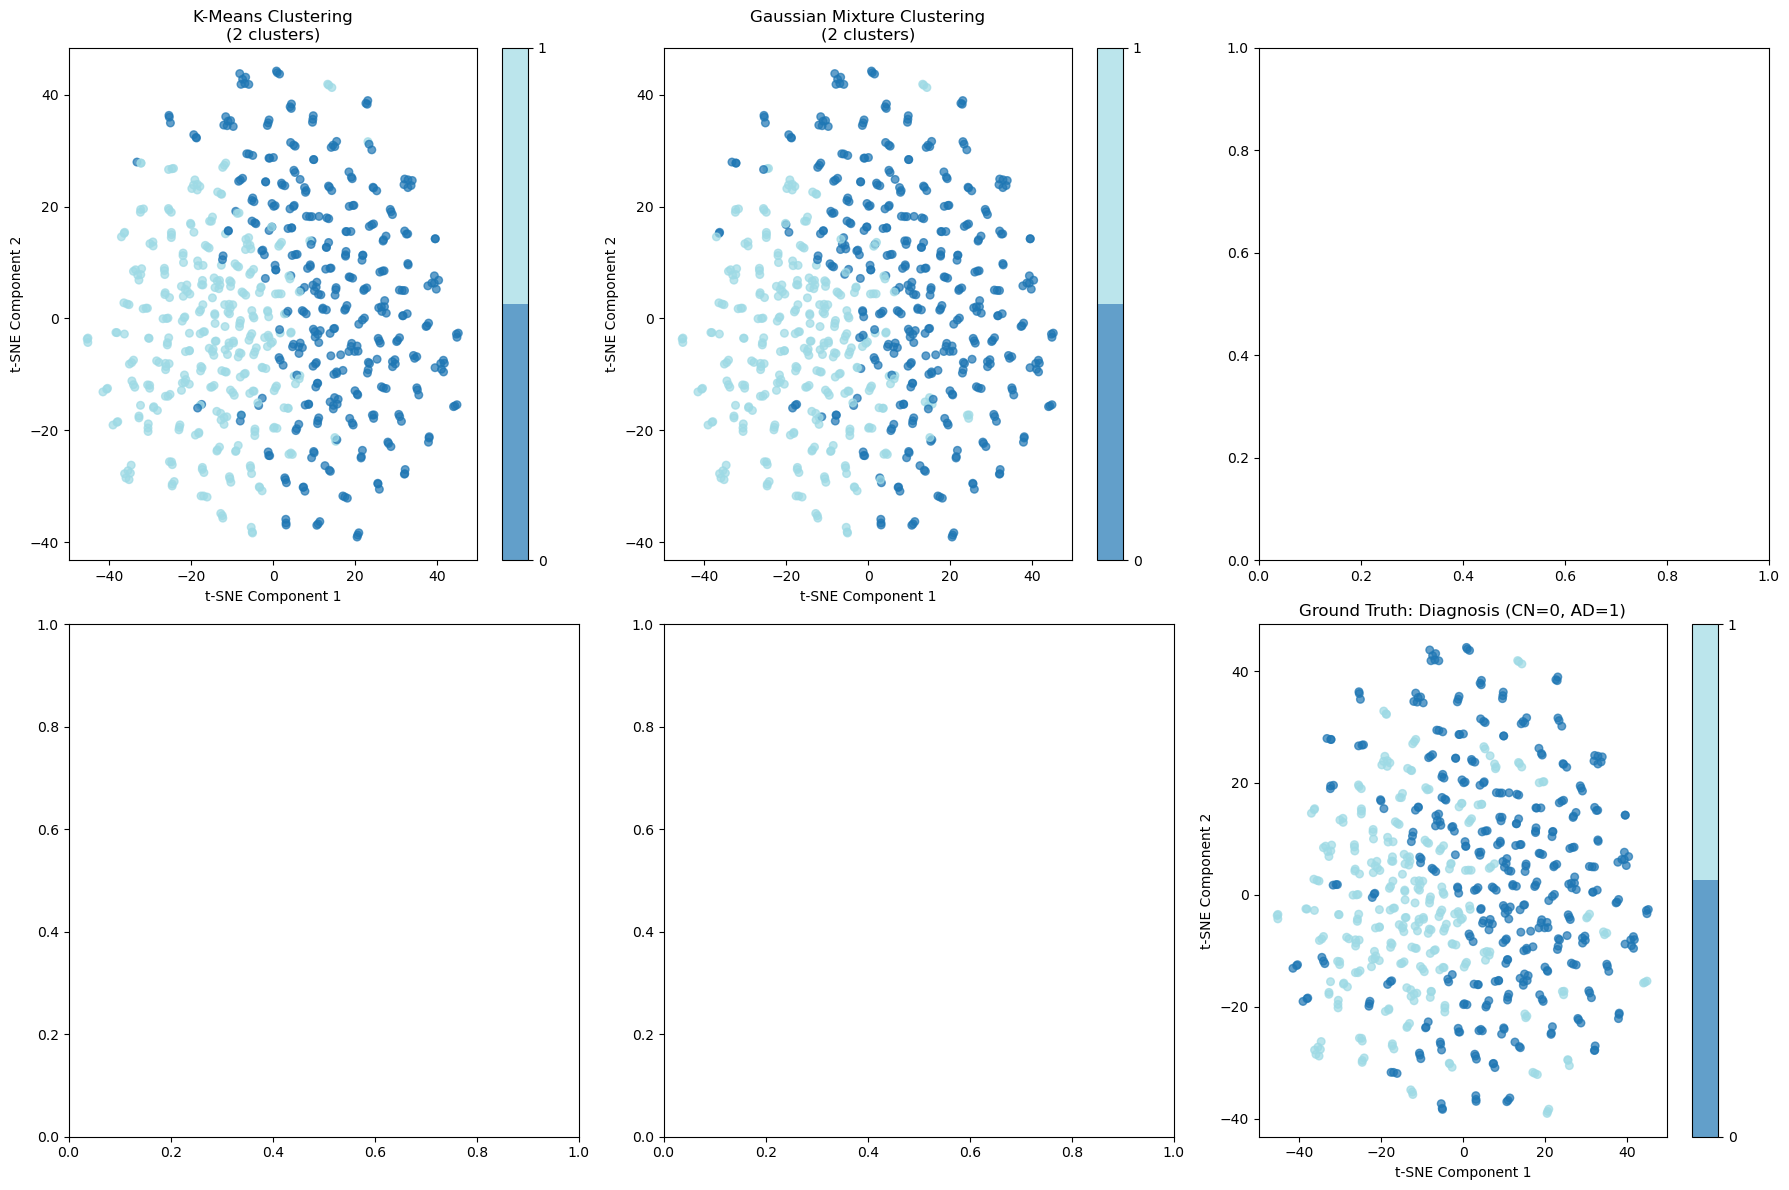

In [36]:
# 6. Visualize clustering results using dimensionality reduction
print('\n6. Visualization of Clustering Results:')

import numpy as np

embedding_label = 'UMAP'
try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    print('Using UMAP for visualization')
except Exception as e:
    from sklearn.manifold import TSNE
    embedding_label = 't-SNE'
    print(f'UMAP failed ({e}); using t-SNE for visualization')
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_umap = tsne.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

methods = ['KMeans_Best', 'GMM_Best', 'DBSCAN_Best', 'Hierarchical_Best', 'Spectral_Best']
method_names = ['K-Means', 'Gaussian Mixture', 'DBSCAN', 'Hierarchical', 'Spectral']

all_labels = []
for method in methods:
    if method in clustering_results:
        all_labels.append(np.asarray(clustering_results[method]))
all_labels.append(np.asarray(diagnosis))

unique_labels = sorted(set(np.concatenate(all_labels)))
if -1 in unique_labels:
    label_order = [-1] + [label for label in unique_labels if label != -1]
else:
    label_order = unique_labels

cmap = plt.get_cmap('tab20', len(label_order))
label_to_index = {label: idx for idx, label in enumerate(label_order)}

def map_labels(labels):
    return np.vectorize(label_to_index.get)(labels)

for i, (method, name) in enumerate(zip(methods, method_names)):
    if method in clustering_results:
        labels = clustering_results[method]
        if method == 'GMM_Best':
            # Swap 0 and 1 for visualization only to align with ground truth colors.
            labels = np.where(labels == 0, 1, np.where(labels == 1, 0, labels))
        color_ids = map_labels(labels)
        scatter = axes[i].scatter(
            X_umap[:, 0], X_umap[:, 1],
            c=color_ids, cmap=cmap,
            vmin=0, vmax=len(label_order) - 1,
            alpha=0.7, s=30
        )
        axes[i].set_title(f'{name} Clustering\n({len(set(labels))} clusters)')
        axes[i].set_xlabel(f'{embedding_label} Component 1')
        axes[i].set_ylabel(f'{embedding_label} Component 2')
        cbar = plt.colorbar(scatter, ax=axes[i], ticks=range(len(label_order)))
        cbar.ax.set_yticklabels(label_order)

gt_colors = map_labels(diagnosis)
scatter = axes[5].scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=gt_colors, cmap=cmap,
    vmin=0, vmax=len(label_order) - 1,
    alpha=0.7, s=30
 )
axes[5].set_title('Ground Truth: Diagnosis (CN=0, AD=1)')
axes[5].set_xlabel(f'{embedding_label} Component 1')
axes[5].set_ylabel(f'{embedding_label} Component 2')
cbar = plt.colorbar(scatter, ax=axes[5], ticks=range(len(label_order)))
cbar.ax.set_yticklabels(label_order)

plt.tight_layout()
plt.savefig('clustering_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# 7. Analyze cluster characteristics
print('\n7. Cluster Analysis:')

best_labels = clustering_results['KMeans_Best']
unique_clusters = sorted(set(best_labels))

print(f'\nAnalyzing K-Means clustering with {len(unique_clusters)} clusters:')

cluster_analysis = {}
for cluster_id in unique_clusters:
    cluster_mask = best_labels == cluster_id

    cluster_diag_ratio = np.mean(diagnosis[cluster_mask] == 1) if np.any(cluster_mask) else float('nan')
    cluster_vol_mean = np.mean(volume[cluster_mask]) if np.any(cluster_mask) else float('nan')
    cluster_vol_std = np.std(volume[cluster_mask]) if np.any(cluster_mask) else float('nan')
    cluster_size = np.sum(cluster_mask)

    cluster_analysis[cluster_id] = {
        'size': cluster_size,
        'ad_ratio': cluster_diag_ratio,
        'volume_mean': cluster_vol_mean,
        'volume_std': cluster_vol_std,
    }

    print(f'Cluster {cluster_id}:')
    print(f'  Size: {cluster_size} samples')
    print(f'  AD ratio: {cluster_diag_ratio:.3f}')
    print(f'  Volume mean±std: {cluster_vol_mean:.3f}±{cluster_vol_std:.3f}')

# 8. Create new labels from clustering
print('\n8. Creating Training Labels from Clusters:')

cluster_labels_for_training = best_labels
np.save('unsupervised_cluster_labels.npy', cluster_labels_for_training)
print("Saved cluster labels to 'unsupervised_cluster_labels.npy'")
print(f'Shape: {cluster_labels_for_training.shape}')
print(f'Unique clusters: {sorted(set(cluster_labels_for_training))}')


In [ ]:
# 9. Map cluster IDs to diagnosis labels (CN/AD)
print('\n9. Cluster-to-Diagnosis Mapping:')

def summarize_cluster_labels(labels, diagnosis):
    mapping = {}
    unique_clusters = sorted(set(labels))
    for cluster_id in unique_clusters:
        mask = labels == cluster_id
        cn_count = int((diagnosis[mask] == 0).sum())
        ad_count = int((diagnosis[mask] == 1).sum())
        total = cn_count + ad_count
        if total == 0:
            majority_label = 'N/A'
            majority_ratio = float('nan')
        else:
            majority_label = 'AD' if ad_count >= cn_count else 'CN'
            majority_ratio = max(ad_count, cn_count) / total
        mapping[cluster_id] = {
            'size': total,
            'cn': cn_count,
            'ad': ad_count,
            'majority_label': majority_label,
            'majority_ratio': majority_ratio,
        }
        print(f'  Cluster {cluster_id}: CN={cn_count}, AD={ad_count}, '
              f'majority={majority_label} ({majority_ratio:.2%})')

    total_correct = sum(max(stats['cn'], stats['ad']) for stats in mapping.values())
    total = sum(stats['size'] for stats in mapping.values())
    if total > 0:
        print(f'  Purity (majority-vote accuracy): {total_correct / total:.3%}')
    return mapping

# Evaluate all available clustering methods
for method_name, labels in clustering_results.items():
    print(f'\nMethod: {method_name}')
    summarize_cluster_labels(labels, diagnosis)


In [ ]:
# 10. Create pseudo labels from GMM_Best clusters and analyze volume
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

print('\n10. Creating pseudo labels from GMM_Best clusters...')

if 'GMM_Best' not in clustering_results:
    print('GMM_Best not found in clustering_results.')
else:
    gmm_labels = clustering_results['GMM_Best']
    if len(gmm_labels) != len(valid_filenames):
        print(f'Warning: label count mismatch: {len(gmm_labels)} vs {len(valid_filenames)}')

    diag_mask = diagnosis >= 0
    cluster_ids = sorted(set(gmm_labels))
    cluster_ad_ratio = {}
    for cid in cluster_ids:
        mask = (gmm_labels == cid) & diag_mask
        if np.any(mask):
            cluster_ad_ratio[cid] = np.mean(diagnosis[mask] == 1)
        else:
            cluster_ad_ratio[cid] = float('nan')
        print(f'Cluster {cid}: AD ratio = {cluster_ad_ratio[cid]:.3f}')

    valid_ratios = {cid: r for cid, r in cluster_ad_ratio.items() if np.isfinite(r)}
    if not valid_ratios:
        print('No valid diagnosis labels to map clusters.')
    else:
        ad_cluster = max(valid_ratios, key=valid_ratios.get)
        cn_cluster = min(valid_ratios, key=valid_ratios.get)
        print(f'Assigning AD to cluster {ad_cluster}, CN to cluster {cn_cluster}')

        pseudo_diag = np.full(len(gmm_labels), -1, dtype=int)
        pseudo_diag[gmm_labels == ad_cluster] = 1
        pseudo_diag[gmm_labels == cn_cluster] = 0

        other_clusters = [c for c in cluster_ids if c not in (ad_cluster, cn_cluster)]
        if other_clusters:
            print(f'Warning: more than 2 clusters, assigning CN to clusters {other_clusters}')
            for c in other_clusters:
                pseudo_diag[gmm_labels == c] = 0

        if os.path.exists(labels_path):
            pseudo_labels = {}
            for idx, filename in enumerate(valid_filenames):
                base_name = os.path.splitext(os.path.basename(filename))[0]
                if base_name not in label_map:
                    print(f'Warning: No label found for {base_name}')
                    continue
                label = label_map[base_name]
                if isinstance(label, torch.Tensor):
                    label_tensor = label.clone()
                else:
                    label_tensor = torch.tensor(label, dtype=torch.float32)

                if label_tensor.ndim == 0:
                    label_tensor = label_tensor.view(1)
                label_tensor = label_tensor.view(-1)

                # [pseudo_diag, real_diag, age, sex, volume, ...]
                pseudo_value = torch.tensor(pseudo_diag[idx], dtype=label_tensor.dtype)
                pseudo_label = torch.cat([pseudo_value.view(1), label_tensor], dim=0)
                pseudo_labels[base_name] = pseudo_label

            pseudo_path = os.path.join(mesh_root, 'pseudo_label_gmm.pt')
            torch.save(pseudo_labels, pseudo_path)
            print(f'Saved pseudo labels to {pseudo_path}')
        else:
            print(f'labels.pt not found at {labels_path}; cannot save pseudo labels.')

        if 'pseudo_labels' in locals():
            pseudo_diag_list = []
            pseudo_volumes = []
            for filename in valid_filenames:
                base_name = os.path.splitext(os.path.basename(filename))[0]
                if base_name in pseudo_labels:
                    lbl = pseudo_labels[base_name]
                    pseudo_diag_list.append(int(lbl[0].item()))
                    if lbl.numel() > 4:
                        pseudo_volumes.append(float(lbl[4].item()))
                    else:
                        pseudo_volumes.append(float('nan'))
                else:
                    pseudo_diag_list.append(-1)
                    pseudo_volumes.append(float('nan'))

            pseudo_diag_arr = np.array(pseudo_diag_list)
            pseudo_vol_arr = np.array(pseudo_volumes, dtype=float)

            vol_mask = np.isfinite(pseudo_vol_arr)
            cn_mask = (pseudo_diag_arr == 0) & vol_mask
            ad_mask = (pseudo_diag_arr == 1) & vol_mask

            cn_vol = pseudo_vol_arr[cn_mask]
            ad_vol = pseudo_vol_arr[ad_mask]

            if cn_vol.size > 0:
                print(f'Pseudo CN volume mean±std: {np.mean(cn_vol):.4f}±{np.std(cn_vol):.4f}')
            if ad_vol.size > 0:
                print(f'Pseudo AD volume mean±std: {np.mean(ad_vol):.4f}±{np.std(ad_vol):.4f}')

            plt.figure(figsize=(6, 5))
            box = plt.boxplot(
                [cn_vol, ad_vol],
                labels=['CN (pseudo)', 'AD (pseudo)'],
                showfliers=True,
                showmeans=True,
                meanline=True,
                boxprops={'linewidth': 2},
                whiskerprops={'linewidth': 2},
                capprops={'linewidth': 2},
                medianprops={'color': 'none', 'linewidth': 0},
                meanprops={'color': 'black', 'linewidth': 2},
            )
            jitter = 0.08
            if cn_vol.size > 0:
                plt.scatter(
                    np.random.normal(1, jitter, size=cn_vol.size),
                    cn_vol,
                    s=12, alpha=0.4, color='#A7C7E7', edgecolors='none'
                )
            if ad_vol.size > 0:
                plt.scatter(
                    np.random.normal(2, jitter, size=ad_vol.size),
                    ad_vol,
                    s=12, alpha=0.4, color='#F4A6A6', edgecolors='none'
                )
            plt.ylabel('Volume')
            plt.title('Pseudo-label Volume Distribution (GMM_Best)')
            plt.grid(True, axis='y', alpha=0.3)
            plt.show()


In [40]:
# 11. Unsupervised HLLE+ICA component ranking (stability + reconstruction impact)
if 'X' not in globals():
    raise RuntimeError('X not found. Run the latent loading cell first.')

if 'best_params' in globals() and best_params is not None:
    n_neighbors = best_params[0]
    n_components = best_params[1]
else:
    n_neighbors = 300
    n_components = 4
    print('best_params not found; using defaults.')

hlle_full = LocallyLinearEmbedding(
    n_neighbors=n_neighbors,
    n_components=n_components,
    method='hessian',
    eigen_solver='dense'
)
Z_full = hlle_full.fit_transform(X)

ica_full = FastICA(n_components=n_components, random_state=42)
Y_full = ica_full.fit_transform(Z_full)

Z_recon_full = ica_full.inverse_transform(Y_full)
mse_full = np.mean((Z_full - Z_recon_full) ** 2)

impact = []
for i in range(n_components):
    Y_mask = Y_full.copy()
    Y_mask[:, i] = 0.0
    Z_recon = ica_full.inverse_transform(Y_mask)
    mse_i = np.mean((Z_full - Z_recon) ** 2)
    impact.append(mse_i - mse_full)
impact = np.asarray(impact)

n_boot = 5
sample_frac = 0.8
rng = np.random.default_rng(42)
stability_scores = np.zeros(n_components)
valid_runs = 0

def _safe_corr(a, b):
    mask = np.isfinite(a) & np.isfinite(b)
    if mask.sum() < 2:
        return 0.0
    a = a[mask]
    b = b[mask]
    if np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return abs(np.corrcoef(a, b)[0, 1])

def _greedy_match(corr):
    corr = corr.copy()
    matched = [-1] * n_components
    used_rows = set()
    used_cols = set()
    for _ in range(n_components):
        max_val = -np.inf
        max_r = -1
        max_c = -1
        for r in range(n_components):
            if r in used_rows:
                continue
            for c in range(n_components):
                if c in used_cols:
                    continue
                val = corr[r, c]
                if val > max_val:
                    max_val = val
                    max_r = r
                    max_c = c
        if max_r == -1:
            break
        matched[max_r] = max_c
        used_rows.add(max_r)
        used_cols.add(max_c)
    return matched

for b in range(n_boot):
    idx = rng.choice(X.shape[0], size=int(X.shape[0] * sample_frac), replace=True)
    n_neighbors_b = min(n_neighbors, len(idx) - 1)
    if n_neighbors_b < 2:
        continue
    try:
        hlle_b = LocallyLinearEmbedding(
            n_neighbors=n_neighbors_b,
            n_components=n_components,
            method='hessian',
            eigen_solver='dense'
        )
        Z_b = hlle_b.fit_transform(X[idx])
        ica_b = FastICA(n_components=n_components, random_state=42 + b)
        Y_b = ica_b.fit_transform(Z_b)

        corr = np.zeros((n_components, n_components))
        for i in range(n_components):
            for j in range(n_components):
                corr[i, j] = _safe_corr(Y_full[idx, i], Y_b[:, j])

        matched = _greedy_match(corr)
        for i, j in enumerate(matched):
            if j >= 0:
                stability_scores[i] += corr[i, j]
        valid_runs += 1
    except Exception as e:
        print(f'Bootstrap {b} failed: {e}')

if valid_runs > 0:
    stability_scores /= valid_runs
else:
    stability_scores[:] = np.nan

def _normalize(x):
    x = np.asarray(x, dtype=float)
    if np.all(np.isnan(x)):
        return x
    min_x = np.nanmin(x)
    max_x = np.nanmax(x)
    if np.isclose(max_x, min_x):
        return np.zeros_like(x)
    return (x - min_x) / (max_x - min_x)

impact_norm = _normalize(impact)
stability_norm = _normalize(stability_scores)
combined = 0.5 * impact_norm + 0.5 * stability_norm

order = np.argsort(-combined)
print('\nUnsupervised HLLE+ICA component ranking (higher is more significant):')
for rank, i in enumerate(order, 1):
    print(f'{rank}. component_{i}: stability={stability_scores[i]:.3f}, impact={impact[i]:.6f}, score={combined[i]:.3f}')

unsupervised_scores = {
    'stability': stability_scores,
    'impact': impact,
    'combined': combined,
    'order': order,
    'n_neighbors': n_neighbors,
    'n_components': n_components,
    'n_boot': n_boot,
    'sample_frac': sample_frac,
}



Unsupervised HLLE+ICA component ranking (higher is more significant):
1. component_2: stability=0.942, impact=0.000359, score=0.500
2. component_1: stability=0.930, impact=0.000359, score=0.482
3. component_3: stability=0.897, impact=0.000359, score=0.428
4. component_0: stability=0.631, impact=0.000359, score=0.000


In [ ]:
# 12. Inspect pseudo_label.pt contents
pseudo_path = os.path.join(mesh_root, 'pseudo_label_gmm.pt')
print(f'Looking for: {pseudo_path}')
if os.path.exists(pseudo_path):
    pseudo = torch.load(pseudo_path, map_location='cpu')
    print('type:', type(pseudo))
    if isinstance(pseudo, dict):
        keys = list(pseudo.keys())
        print('num_keys:', len(keys))
        print('first_keys:', keys[:5])
        print('\nSample entries:')
        for k in keys[:3]:
            print(k, '->', pseudo[k])
    else:
        print(pseudo)
else:
    print('pseudo_label.pt not found; run the pseudo-label creation cell first.')


In [ ]:
# 12b. Show pseudo_label.pt schema (pseudo + real + metadata)
pseudo_path = os.path.join(mesh_root, 'pseudo_label_gmm.pt')
print(f'Looking for: {pseudo_path}')
if os.path.exists(pseudo_path):
    pseudo = torch.load(pseudo_path, map_location='cpu')
    if isinstance(pseudo, dict) and pseudo:
        sample_key = next(iter(pseudo))
        sample = pseudo[sample_key]
        field_names = ['pseudo_diag', 'real_diag', 'age', 'sex', 'volume']
        if sample.numel() > len(field_names):
            field_names += [f'field_{i}' for i in range(len(field_names), sample.numel())]
        print('sample:', sample_key)
        print('entry length:', sample.numel())
        for i in range(sample.numel()):
            name = field_names[i] if i < len(field_names) else f'field_{i}'
            val = sample[i].item() if hasattr(sample[i], 'item') else sample[i]
            print(f'{i}: {name} = {val}')
    else:
        print('pseudo_label.pt has no entries or is not a dict.')
else:
    print('pseudo_label.pt not found; run the pseudo-label creation cell first.')


In [ ]:
# 12c. Compare labels.pt vs pseudo_label.pt (real labels)
import numpy as np

labels_path = os.path.join(mesh_root, 'labels.pt')
pseudo_path = os.path.join(mesh_root, 'pseudo_label_gmm.pt')
print(f'labels.pt: {labels_path}')
print(f'pseudo_label.pt: {pseudo_path}')

if not os.path.exists(labels_path):
    print('labels.pt not found.')
elif not os.path.exists(pseudo_path):
    print('pseudo_label.pt not found.')
else:
    labels_raw = torch.load(labels_path, map_location='cpu')
    pseudo_raw = torch.load(pseudo_path, map_location='cpu')

    if isinstance(labels_raw, dict):
        label_map = labels_raw
    elif hasattr(labels_raw, '__len__') and len(labels_raw) == len(valid_filenames):
        label_map = {}
        for idx, filename in enumerate(valid_filenames):
            base_name = os.path.splitext(os.path.basename(filename))[0]
            label_map[base_name] = labels_raw[idx]
    else:
        label_map = {}
        print('labels.pt is not a dict and length does not match filenames.')

    if isinstance(pseudo_raw, dict):
        pseudo_map = pseudo_raw
    else:
        pseudo_map = {}
        print('pseudo_label.pt is not a dict.')

    label_keys = set(label_map.keys())
    pseudo_keys = set(pseudo_map.keys())
    compare_keys = sorted(pseudo_keys)

    total_pseudo = len(compare_keys)
    missing_in_label = len(pseudo_keys - label_keys)

    mismatch_total = 0
    length_mismatch = 0
    value_mismatch = 0

    pseudo_vs_real_mismatch = 0

    for k in compare_keys:
        if k not in label_map:
            continue
        lbl = label_map[k]
        ps = pseudo_map[k]

        lbl_t = torch.as_tensor(lbl).view(-1)
        ps_t = torch.as_tensor(ps).view(-1)

        if ps_t.numel() < lbl_t.numel() + 1:
            mismatch_total += 1
            length_mismatch += 1
            continue

        ps_real = ps_t[1:1 + lbl_t.numel()]
        matches = torch.isclose(lbl_t, ps_real, rtol=1e-4, atol=1e-5, equal_nan=True)
        if not bool(matches.all()):
            mismatch_total += 1
            value_mismatch += 1

        if lbl_t.numel() > 0 and ps_t.numel() > 0:
            if int(lbl_t[0].item()) != int(ps_t[0].item()):
                pseudo_vs_real_mismatch += 1

    if total_pseudo == 0:
        print('No scans in pseudo_label.pt to compare.')
    else:
        mismatch_pct = 100.0 * mismatch_total / total_pseudo
        pseudo_vs_real_pct = 100.0 * pseudo_vs_real_mismatch / total_pseudo
        print(f'Pseudo scans: {total_pseudo}')
        print(f'Missing in labels.pt: {missing_in_label}')
        print(
            f'Mismatched (real labels vs pseudo real labels): {mismatch_total} '
            f'({mismatch_pct:.2f}%)'
        )
        print(
            f'Pseudo diagnosis vs real diagnosis mismatches: {pseudo_vs_real_mismatch} '
            f'({pseudo_vs_real_pct:.2f}%)'
        )
        if length_mismatch or value_mismatch:
            print(f'  length mismatches: {length_mismatch}')
            print(f'  value mismatches: {value_mismatch}')


In [ ]:
# 13. GMM clustering on PCA/ICA/HLLE+ICA/NMF/FA embeddings
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

print('\n13. GMM clustering on PCA/ICA/HLLE+ICA/NMF/FA embeddings (K=2 fixed):')

if 'results' not in globals():
    raise RuntimeError('results not found. Run the embedding cells first.')

if 'clustering_results' not in globals():
    clustering_results = {}

k_fixed = 2

embedding_sources = {
    'PCA': results.get('PCA'),
    'ICA': results.get('ICA'),
    'HLLE+ICA': results.get('HLLE+ICA'),
    'NMF': results.get('NMF'),
    'FA': results.get('FA'),
}

gmm_scores_by_method = {}
gmm_models_by_method = {}

for name, embedding in embedding_sources.items():
    if embedding is None:
        print(f'{name}: embedding missing, skipping.')
        continue
    if not isinstance(embedding, np.ndarray) or embedding.size == 0:
        print(f'{name}: invalid embedding, skipping.')
        continue

    print(f'\n{name}:')
    scaler = StandardScaler()
    X_emb = scaler.fit_transform(embedding)

    gmm = GaussianMixture(n_components=k_fixed, random_state=42)
    labels = gmm.fit_predict(X_emb)
    sil_score = silhouette_score(X_emb, labels) if len(set(labels)) > 1 else -1.0
    aic_score = gmm.aic(X_emb)
    bic_score = gmm.bic(X_emb)

    gmm_scores_by_method[name] = {
        'silhouette': [sil_score],
        'aic': [aic_score],
        'bic': [bic_score],
    }
    gmm_models_by_method[name] = gmm

    key = f'GMM_Best_{name}'
    clustering_results[key] = labels
    print(f'  K={k_fixed}: Silhouette={sil_score:.3f}, AIC={aic_score:.1f}, BIC={bic_score:.1f}')



14. Visualizing GMM clustering + purity (PCA/ICA/HLLE+ICA/NMF/FA):

PCA purity: 0.819
  cluster 0: size=301, purity=0.794, breakdown={0: 62, 1: 239}
  cluster 1: size=395, purity=0.838, breakdown={0: 331, 1: 64}

ICA purity: 0.819
  cluster 0: size=301, purity=0.794, breakdown={0: 62, 1: 239}
  cluster 1: size=395, purity=0.838, breakdown={0: 331, 1: 64}

HLLE+ICA purity: 0.565
  cluster 0: size=381, purity=0.517, breakdown={0: 197, 1: 184}
  cluster 1: size=315, purity=0.622, breakdown={0: 196, 1: 119}

NMF purity: 0.759
  cluster 0: size=405, purity=0.667, breakdown={0: 135, 1: 270}
  cluster 1: size=291, purity=0.887, breakdown={0: 258, 1: 33}

Factor Analysis purity: 0.803
  cluster 0: size=318, purity=0.761, breakdown={0: 76, 1: 242}
  cluster 1: size=378, purity=0.839, breakdown={0: 317, 1: 61}


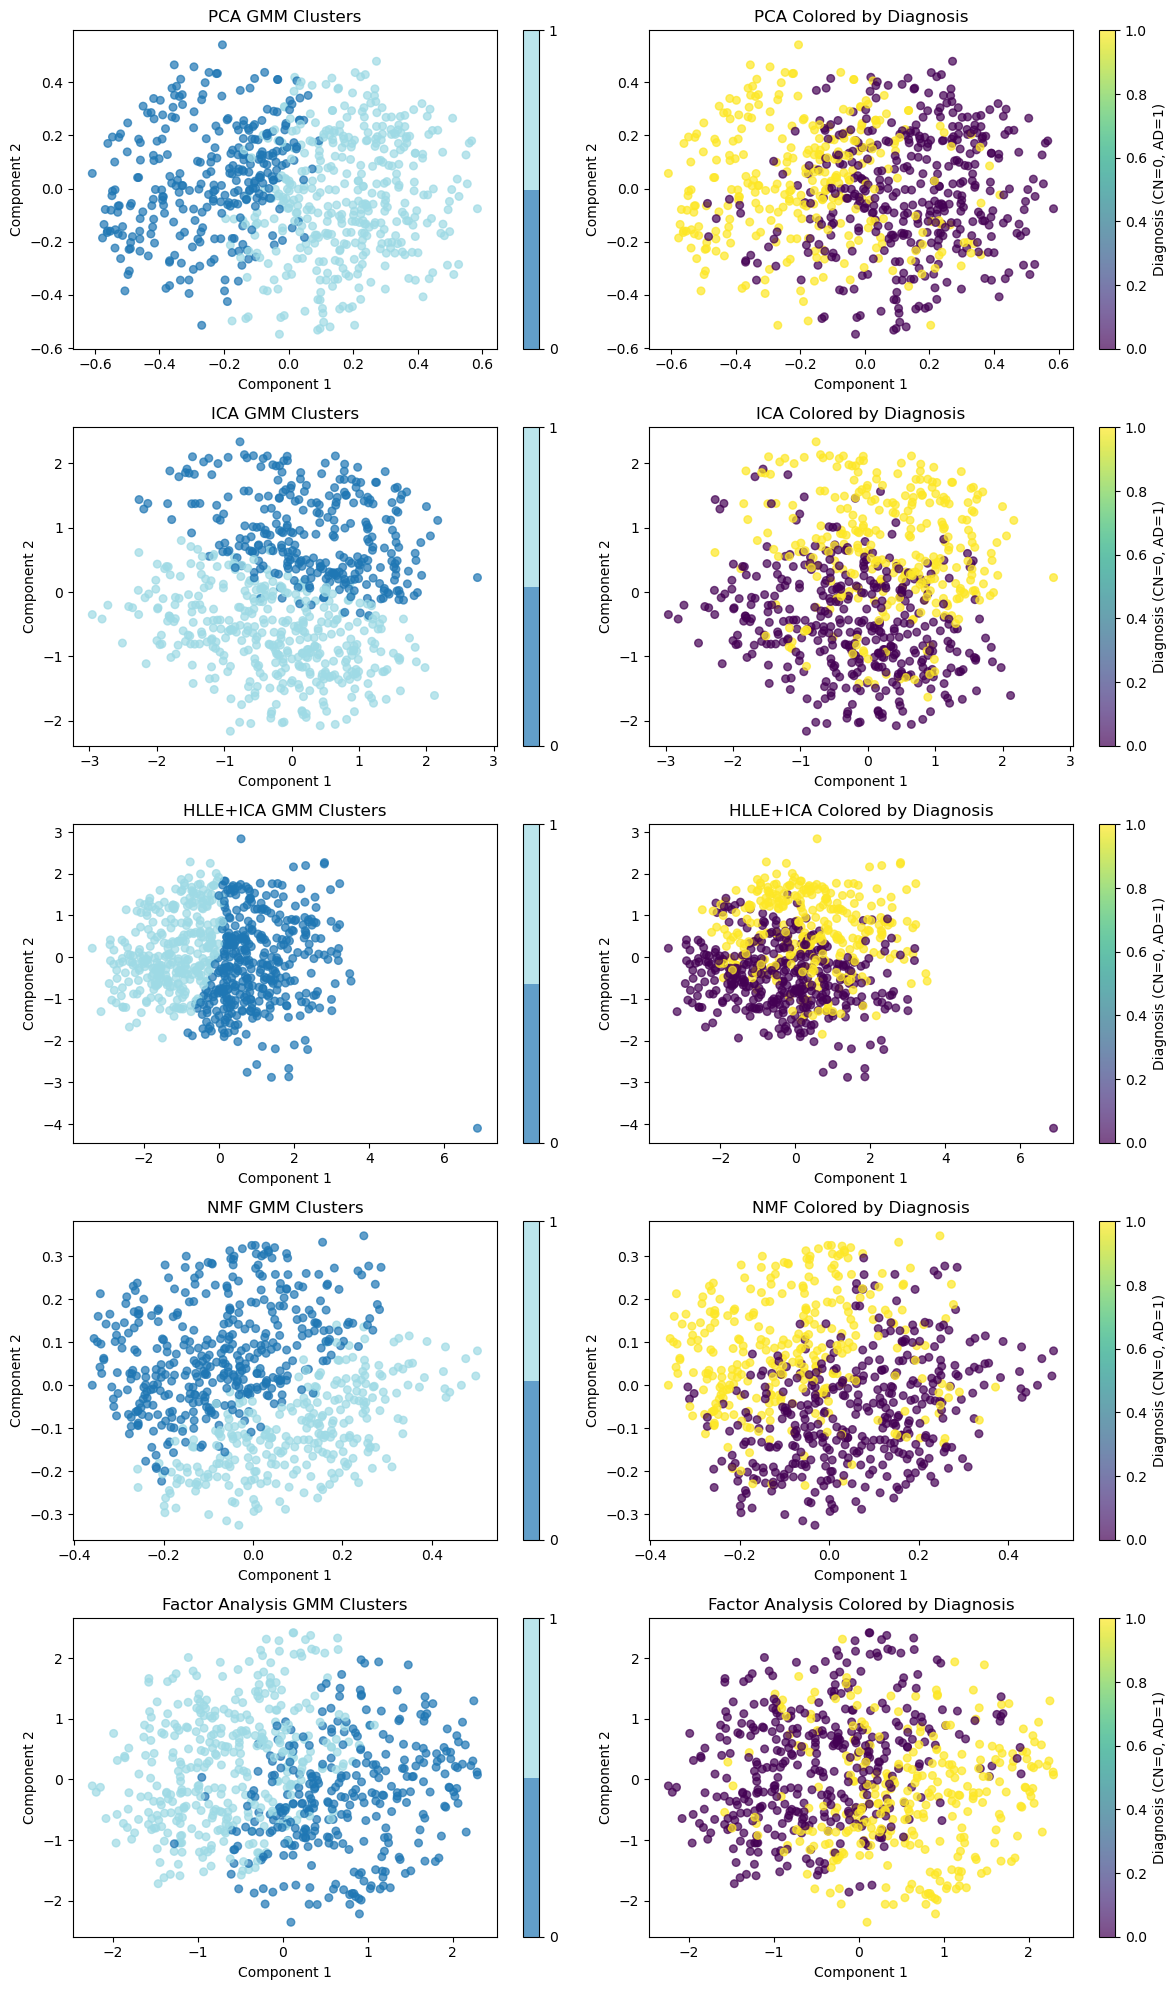

In [49]:
# 14. Visualize GMM clustering results and report purity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print('\n14. Visualizing GMM clustering + purity (PCA/ICA/HLLE+ICA/NMF/FA):')

if 'results' not in globals():
    raise RuntimeError('results not found. Run the embedding cells first.')
if 'clustering_results' not in globals():
    raise RuntimeError('clustering_results not found. Run the GMM clustering cell first.')
if 'diagnosis' not in globals():
    raise RuntimeError('diagnosis not found. Run the data loading cell first.')

def _cluster_purity(labels, targets):
    labels = np.asarray(labels)
    targets = np.asarray(targets)
    mask = np.isfinite(labels) & np.isfinite(targets)
    labels = labels[mask]
    targets = targets[mask]
    if labels.size == 0:
        return float('nan'), {}
    purity_sum = 0
    details = {}
    for label in sorted(set(labels)):
        cluster_mask = labels == label
        cluster_targets = targets[cluster_mask]
        if cluster_targets.size == 0:
            continue
        values, counts = np.unique(cluster_targets, return_counts=True)
        major = counts.max()
        purity = major / counts.sum()
        purity_sum += major
        details[int(label)] = {
            'size': int(counts.sum()),
            'purity': float(purity),
            'breakdown': {int(v): int(c) for v, c in zip(values, counts)},
        }
    overall = purity_sum / labels.size if labels.size > 0 else float('nan')
    return overall, details

methods = ['PCA', 'ICA', 'HLLE+ICA', 'NMF', 'FA']
display_names = {
    'PCA': 'PCA',
    'ICA': 'ICA',
    'HLLE+ICA': 'HLLE+ICA',
    'NMF': 'NMF',
    'FA': 'Factor Analysis',
}
method_keys = []
for method in methods:
    key = f'GMM_Best_{method}'
    if key in clustering_results and results.get(method) is not None:
        method_keys.append((method, key))

if not method_keys:
    print('No GMM results found for PCA/ICA/HLLE+ICA/NMF/FA.')
else:
    n_rows = len(method_keys)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
    if n_rows == 1:
        axes = np.array([axes])

    for row_idx, (method, key) in enumerate(method_keys):
        embedding = results.get(method)
        labels = np.asarray(clustering_results[key])

        if embedding.shape[1] == 1:
            X_vis = np.column_stack([embedding[:, 0], np.zeros(len(embedding))])
        elif embedding.shape[1] == 2:
            X_vis = embedding
        else:
            X_vis = PCA(n_components=2).fit_transform(embedding)

        unique_labels = sorted(set(labels))
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        color_ids = np.vectorize(label_to_index.get)(labels)
        cmap = plt.get_cmap('tab20', max(len(unique_labels), 1))
        method_name = display_names.get(method, method)

        ax_clusters = axes[row_idx, 0]
        sc = ax_clusters.scatter(X_vis[:, 0], X_vis[:, 1], c=color_ids, cmap=cmap, s=30, alpha=0.7)
        ax_clusters.set_title(f'{method_name} GMM Clusters')
        ax_clusters.set_xlabel('Component 1')
        ax_clusters.set_ylabel('Component 2')
        cbar = plt.colorbar(sc, ax=ax_clusters, ticks=range(len(unique_labels)))
        cbar.ax.set_yticklabels(unique_labels)

        ax_diag = axes[row_idx, 1]
        sc2 = ax_diag.scatter(X_vis[:, 0], X_vis[:, 1], c=diagnosis, cmap='viridis', s=30, alpha=0.7)
        ax_diag.set_title(f'{method_name} Colored by Diagnosis')
        ax_diag.set_xlabel('Component 1')
        ax_diag.set_ylabel('Component 2')
        plt.colorbar(sc2, ax=ax_diag, label='Diagnosis (CN=0, AD=1)')

        purity, details = _cluster_purity(labels, diagnosis)
        print(f'\n{method_name} purity: {purity:.3f}')
        for cid in sorted(details):
            info = details[cid]
            print(f"  cluster {cid}: size={info['size']}, purity={info['purity']:.3f}, breakdown={info['breakdown']}")

    plt.tight_layout()
    plt.show()


In [52]:
# 16. High-confidence GMM filtering (purity vs coverage)
import numpy as np
from sklearn.preprocessing import StandardScaler

print('\n16. High-confidence GMM filtering (purity vs coverage):')

if 'gmm_models_by_method' not in globals():
    raise RuntimeError('gmm_models_by_method not found. Run the GMM clustering cell first.')
if 'results' not in globals():
    raise RuntimeError('results not found. Run the embedding cells first.')
if 'diagnosis' not in globals():
    raise RuntimeError('diagnosis not found. Run the label-loading cell first.')

def _cluster_purity(labels, targets):
    labels = np.asarray(labels)
    targets = np.asarray(targets)
    mask = np.isfinite(labels) & np.isfinite(targets) & (targets >= 0)
    labels = labels[mask]
    targets = targets[mask]
    if labels.size == 0:
        return float('nan'), {}
    purity_sum = 0
    details = {}
    for label in sorted(set(labels)):
        cluster_mask = labels == label
        cluster_targets = targets[cluster_mask]
        if cluster_targets.size == 0:
            continue
        values, counts = np.unique(cluster_targets, return_counts=True)
        major = counts.max()
        purity = major / counts.sum()
        purity_sum += major
        details[int(label)] = {
            'size': int(counts.sum()),
            'purity': float(purity),
            'breakdown': {int(v): int(c) for v, c in zip(values, counts)},
        }
    overall = purity_sum / labels.size if labels.size > 0 else float('nan')
    return overall, details

threshold = 0.95  # adjust to trade purity vs coverage

for name, model in gmm_models_by_method.items():
    if model is None:
        print(f'{name}: model missing, skipping.')
        continue
    embedding = results.get(name)
    if embedding is None:
        print(f'{name}: embedding missing, skipping.')
        continue
    scaler = StandardScaler()
    X_emb = scaler.fit_transform(embedding)

    probs = model.predict_proba(X_emb)
    conf = probs.max(axis=1)
    keep = conf >= threshold

    if keep.sum() == 0:
        print(f'{name}: no samples above threshold={threshold:.2f}.')
        continue

    labels = model.predict(X_emb)
    purity, details = _cluster_purity(labels[keep], np.asarray(diagnosis)[keep])
    coverage = float(keep.mean())

    print(f'\n{name}: purity={purity:.3f}, coverage={coverage:.3f} (threshold={threshold:.2f})')
    for cid in sorted(details):
        info = details[cid]
        breakdown = info.get('breakdown', {})
        cn = int(breakdown.get(0, 0))
        ad = int(breakdown.get(1, 0))
        print(f"  cluster {cid}: CN={cn}, AD={ad}, size={info['size']}, purity={info['purity']:.3f}")



16. High-confidence GMM filtering (purity vs coverage):

PCA: purity=0.905, coverage=0.516 (threshold=0.95)
  cluster 0: CN=11, AD=136, size=147, purity=0.925
  cluster 1: CN=189, AD=23, size=212, purity=0.892

ICA: purity=0.905, coverage=0.516 (threshold=0.95)
  cluster 0: CN=11, AD=136, size=147, purity=0.925
  cluster 1: CN=189, AD=23, size=212, purity=0.892

HLLE+ICA: purity=0.565, coverage=0.254 (threshold=0.95)
  cluster 0: CN=73, AD=73, size=146, purity=0.500
  cluster 1: CN=27, AD=4, size=31, purity=0.871

NMF: purity=0.812, coverage=0.496 (threshold=0.95)
  cluster 0: CN=49, AD=223, size=272, purity=0.820
  cluster 1: CN=57, AD=16, size=73, purity=0.781

FA: purity=0.897, coverage=0.542 (threshold=0.95)
  cluster 0: CN=17, AD=158, size=175, purity=0.903
  cluster 1: CN=180, AD=22, size=202, purity=0.891


In [ ]:
# 17. GMM on full latent codes (X) + purity (with confidence filtering)
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

print('\n17. GMM on full latent codes (X) + purity (with confidence filtering):')

if 'X' not in globals():
    raise RuntimeError('X not found. Run the latent loading cell first.')
if 'diagnosis' not in globals():
    raise RuntimeError('diagnosis not found. Run the label-loading cell first.')

def _cluster_purity(labels, targets):
    labels = np.asarray(labels)
    targets = np.asarray(targets)
    mask = np.isfinite(labels) & np.isfinite(targets) & (targets >= 0)
    labels = labels[mask]
    targets = targets[mask]
    if labels.size == 0:
        return float('nan'), {}
    purity_sum = 0
    details = {}
    for label in sorted(set(labels)):
        cluster_mask = labels == label
        cluster_targets = targets[cluster_mask]
        if cluster_targets.size == 0:
            continue
        values, counts = np.unique(cluster_targets, return_counts=True)
        major = counts.max()
        purity = major / counts.sum()
        purity_sum += major
        details[int(label)] = {
            'size': int(counts.sum()),
            'purity': float(purity),
            'breakdown': {int(v): int(c) for v, c in zip(values, counts)},
        }
    overall = purity_sum / labels.size if labels.size > 0 else float('nan')
    return overall, details

k_fixed = 2
threshold = 0.90  # adjust to trade purity vs coverage

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

gmm_latent = GaussianMixture(n_components=k_fixed, random_state=42)
latent_labels = gmm_latent.fit_predict(X_scaled)
latent_probs = gmm_latent.predict_proba(X_scaled)

sil_score = silhouette_score(X_scaled, latent_labels) if len(set(latent_labels)) > 1 else -1.0
aic_score = gmm_latent.aic(X_scaled)
bic_score = gmm_latent.bic(X_scaled)

purity_all, details_all = _cluster_purity(latent_labels, np.asarray(diagnosis))

print(f'K={k_fixed}: Silhouette={sil_score:.3f}, AIC={aic_score:.1f}, BIC={bic_score:.1f}')
print(f'Purity (all): {purity_all:.3f}')
for cid in sorted(details_all):
    info = details_all[cid]
    breakdown = info.get('breakdown', {})
    cn = int(breakdown.get(0, 0))
    ad = int(breakdown.get(1, 0))
    print(f"  cluster {cid}: CN={cn}, AD={ad}, size={info['size']}, purity={info['purity']:.3f}")

conf = latent_probs.max(axis=1)
keep = conf >= threshold
if keep.sum() == 0:
    print(f'No samples above threshold={threshold:.2f}.')
else:
    purity_filt, details_filt = _cluster_purity(latent_labels[keep], np.asarray(diagnosis)[keep])
    coverage = float(keep.mean())
    print(f'\nPurity (filtered): {purity_filt:.3f}, coverage={coverage:.3f} (threshold={threshold:.2f})')
    for cid in sorted(details_filt):
        info = details_filt[cid]
        breakdown = info.get('breakdown', {})
        cn = int(breakdown.get(0, 0))
        ad = int(breakdown.get(1, 0))
        print(f"  cluster {cid}: CN={cn}, AD={ad}, size={info['size']}, purity={info['purity']:.3f}")

gmm_latent_results = {
    'model': gmm_latent,
    'labels': latent_labels,
    'probs': latent_probs,
    'silhouette': sil_score,
    'aic': aic_score,
    'bic': bic_score,
    'purity_all': purity_all,
    'details_all': details_all,
    'threshold': threshold,
}


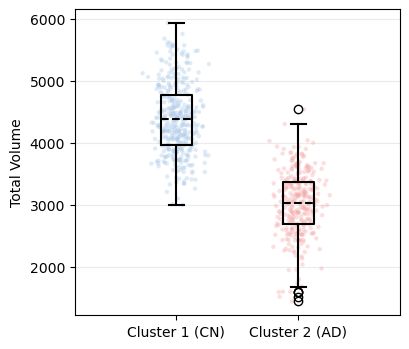

In [10]:
# --- Pseudo-label volume distribution (total L+R) ---
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

if 'mesh_root' not in globals():
    raise RuntimeError('mesh_root not found. Run the data loading cell first.')

left_mesh_root = mesh_root

def _derive_right_path(p):
    if 'left_hippocampus_correspondence' in p:
        return p.replace('left_hippocampus_correspondence', 'right_hippocampus_correspondence')
    if 'left_hippocampus' in p:
        return p.replace('left_hippocampus', 'right_hippocampus')
    return p

right_mesh_root = _derive_right_path(left_mesh_root)

left_labels_path = os.path.join(left_mesh_root, 'labels.pt')
right_labels_path = os.path.join(right_mesh_root, 'labels.pt')

# Load label maps (dict or align by valid_filenames)
def _load_label_map(labels_path):
    labels = torch.load(labels_path, map_location='cpu')
    if isinstance(labels, dict):
        return labels
    if 'valid_filenames' not in globals():
        raise RuntimeError('valid_filenames not found; cannot align non-dict labels')
    label_map = {}
    for idx, filename in enumerate(valid_filenames):
        base_name = os.path.splitext(os.path.basename(filename))[0]
        label_map[base_name] = labels[idx]
    return label_map

left_map = _load_label_map(left_labels_path)
right_map = _load_label_map(right_labels_path)

# Load pseudo labels (use existing if present)
if 'pseudo_labels' in globals():
    pseudo_map = pseudo_labels
else:
    pseudo_path = os.path.join(left_mesh_root, 'pseudo_label_gmm.pt')
    if not os.path.exists(pseudo_path):
        raise FileNotFoundError('Pseudo labels file not found. Generate pseudo labels first.')
    pseudo_map = torch.load(pseudo_path, map_location='cpu')
    if not isinstance(pseudo_map, dict):
        raise RuntimeError('Pseudo labels file is not a dict')

# Normalize keys to match left/right

def _norm_key(k):
    base = os.path.splitext(os.path.basename(str(k)))[0]
    if base.endswith('_left'):
        return base[:-5]
    if base.endswith('_right'):
        return base[:-6]
    return base

left_norm = {_norm_key(k): v for k, v in left_map.items()}
right_norm = {_norm_key(k): v for k, v in right_map.items()}
pseudo_norm = {_norm_key(k): v for k, v in pseudo_map.items()}

# Helpers

def _to_float(x):
    try:
        return float(x.item()) if hasattr(x, 'item') else float(x)
    except Exception:
        return None


def _to_int(x):
    try:
        return int(x.item()) if hasattr(x, 'item') else int(x)
    except Exception:
        return None

# Build arrays
cn_vol = []
ad_vol = []
for key, plab in pseudo_norm.items():
    if key not in left_norm or key not in right_norm:
        continue
    llab = left_norm[key]
    rlab = right_norm[key]

    if llab is None or rlab is None or plab is None:
        continue
    if len(llab) < 4 or len(rlab) < 4:
        continue

    pseudo_diag = _to_int(plab[0]) if len(plab) > 0 else None
    if pseudo_diag not in (0, 1):
        continue

    vol_left = _to_float(llab[3])
    vol_right = _to_float(rlab[3])
    if vol_left is None or vol_right is None:
        continue

    total_vol = vol_left + vol_right
    if pseudo_diag == 0:
        cn_vol.append(total_vol)
    else:
        ad_vol.append(total_vol)

cn_vol = np.array(cn_vol, dtype=float)
ad_vol = np.array(ad_vol, dtype=float)

# Compact plot
plt.figure(figsize=(4.2, 3.6))
positions = [1.0, 1.6]
box = plt.boxplot(
    [cn_vol, ad_vol],
    positions=positions,
    showfliers=True,
    showmeans=True,
    meanline=True,
    boxprops={'linewidth': 1.5},
    whiskerprops={'linewidth': 1.5},
    capprops={'linewidth': 1.5},
    medianprops={'color': 'none', 'linewidth': 0},
    meanprops={'color': 'black', 'linewidth': 1.5},
)
ax = plt.gca()
ax.set_xticks(positions)
ax.set_xticklabels(['Cluster 1 (CN)', 'Cluster 2 (AD)'])

jitter = 0.06
if cn_vol.size > 0:
    plt.scatter(
        np.random.normal(1.0, jitter, size=cn_vol.size),
        cn_vol,
        s=10, alpha=0.35, color='#A7C7E7', edgecolors='none'
    )
if ad_vol.size > 0:
    plt.scatter(
        np.random.normal(1.6, jitter, size=ad_vol.size),
        ad_vol,
        s=10, alpha=0.35, color='#F4A6A6', edgecolors='none'
    )

plt.ylabel('Total Volume')
#plt.title('Pseudo Label Volume Distribution')
plt.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
# 18. KNN prediction from most-correlated component (PCA / ICA / HLLE+ICA)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score

def _best_corr_component(embedding, target, mask):
    embedding = np.asarray(embedding)
    target = np.asarray(target)
    if embedding.ndim != 2:
        return None
    if mask is None:
        mask = np.ones(len(embedding), dtype=bool)
    mask = mask & np.all(np.isfinite(embedding), axis=1) & np.isfinite(target)
    if not np.any(mask):
        return None
    corrs = []
    for i in range(embedding.shape[1]):
        x = embedding[mask, i]
        y = target[mask]
        if np.std(x) == 0 or np.std(y) == 0:
            corrs.append(np.nan)
        else:
            corrs.append(np.corrcoef(x, y)[0, 1])
    corrs = np.array(corrs, dtype=float)
    if np.all(~np.isfinite(corrs)):
        return None
    best_idx = int(np.nanargmax(np.abs(corrs)))
    return best_idx, corrs

def _knn_classify_1d(x, y, k=5):
    X = x.reshape(-1, 1)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)
    k_eff = max(1, min(k, len(X_train_s)))
    clf = KNeighborsClassifier(n_neighbors=k_eff)
    clf.fit(X_train_s, y_train)
    y_pred = clf.predict(X_val_s)
    acc = accuracy_score(y_val, y_pred)
    auc = float('nan')
    if len(np.unique(y)) > 1 and hasattr(clf, 'predict_proba'):
        y_proba = clf.predict_proba(X_val_s)[:, 1]
        auc = roc_auc_score(y_val, y_proba)
    return acc, auc, len(y_train), len(y_val)

def _knn_regress_1d(x, y, k=5):
    X = x.reshape(-1, 1)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)
    k_eff = max(1, min(k, len(X_train_s)))
    reg = KNeighborsRegressor(n_neighbors=k_eff)
    reg.fit(X_train_s, y_train)
    y_pred = reg.predict(X_val_s)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)
    return mae, rmse, r2, len(y_train), len(y_val)

embedding_sources = {
    'PCA': results.get('PCA') if 'results' in globals() else None,
    'ICA': results.get('ICA') if 'results' in globals() else None,
    'HLLE+ICA': results.get('HLLE+ICA') if 'results' in globals() else None,
}

print('\nKNN prediction using most-correlated component (1D):')

for name, emb in embedding_sources.items():
    if emb is None:
        print(f'{name}: embedding missing, skipping.')
        continue
    emb = np.asarray(emb)

    # Disease prediction (diagnosis == 1)
    if 'diagnosis' not in globals():
        print(f'{name}: diagnosis missing, skipping disease prediction.')
    else:
        mask = diagnosis >= 0
        res = _best_corr_component(emb, diagnosis, mask)
        if res is None:
            print(f'{name}: cannot compute disease correlation.')
        else:
            best_idx, corrs = res
            best_corr = corrs[best_idx]
            y = (diagnosis[mask] == 1).astype(int)
            x = emb[mask, best_idx]
            if len(np.unique(y)) < 2:
                print(f'{name}: only one class in diagnosis, skipping KNN.')
            else:
                acc, auc, ntr, nva = _knn_classify_1d(x, y, k=5)
                print(f'{name} disease: comp {best_idx + 1} corr={best_corr:.4f}, acc={acc:.3f}, auc={auc:.3f} (n_train={ntr}, n_val={nva})')

    # Age prediction
    if 'age' not in globals():
        print(f'{name}: age missing, skipping age prediction.')
    else:
        mask = np.isfinite(age)
        res = _best_corr_component(emb, age, mask)
        if res is None:
            print(f'{name}: cannot compute age correlation.')
        else:
            best_idx, corrs = res
            best_corr = corrs[best_idx]
            x = emb[mask, best_idx]
            y = age[mask]
            if len(y) < 5:
                print(f'{name}: not enough age samples, skipping KNN.')
            else:
                mae, rmse, r2, ntr, nva = _knn_regress_1d(x, y, k=5)
                print(f'{name} age: comp {best_idx + 1} corr={best_corr:.4f}, MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f} (n_train={ntr}, n_val={nva})')

                y_min = float(np.nanmin(y))
                y_max = float(np.nanmax(y))
                y_range = y_max - y_min
                if y_range <= 0:
                    print(f'{name} age norm: range=0, skipping normalized age.')
                else:
                    y_norm = (y - y_min) / y_range
                    mae_n, rmse_n, r2_n, ntr, nva = _knn_regress_1d(x, y_norm, k=5)
                    print(f'{name} age norm: comp {best_idx + 1} corr={best_corr:.4f}, MAE={mae_n:.3f}, RMSE={rmse_n:.3f}, R2={r2_n:.3f} (n_train={ntr}, n_val={nva})')


In [ ]:
# 19. SAP summary for disease and age (PCA / ICA / HLLE+ICA)
import numpy as np
from sdf_utils import sap as sap_metric

if '_mask_codes_factors' not in globals():
    def _mask_codes_factors(codes, factors, mask=None):
        codes = np.asarray(codes)
        factors = np.asarray(factors)
        if factors.ndim == 1:
            factors = factors.reshape(-1, 1)
        if codes.shape[0] != factors.shape[0]:
            print(f'  Skipping: codes/factors row mismatch ({codes.shape[0]} vs {factors.shape[0]})')
            return None, None
        if mask is not None:
            codes = codes[mask]
            factors = factors[mask]
        finite_mask = np.isfinite(factors).all(axis=1) & np.isfinite(codes).all(axis=1)
        codes = codes[finite_mask]
        factors = factors[finite_mask]
        if codes.shape[0] < 4:
            print('  Skipping: not enough valid samples after filtering.')
            return None, None
        return codes, factors

def _sap_disease_score(codes, diagnosis, nb_bins=10):
    mask = diagnosis >= 0
    codes_m, factors_m = _mask_codes_factors(codes, diagnosis, mask=mask)
    if codes_m is None:
        return None
    return sap_metric.sap(
        factors_m,
        codes_m,
        continuous_factors=False,
        nb_bins=nb_bins,
        regression=False,
    )

def _sap_age_score(codes, age):
    mask = np.isfinite(age)
    codes_m, factors_m = _mask_codes_factors(codes, age, mask=mask)
    if codes_m is None:
        return None
    return sap_metric.sap(
        factors_m,
        codes_m,
        continuous_factors=True,
        regression=True,
    )

embedding_sources = {
    'PCA': results.get('PCA') if 'results' in globals() else None,
    'ICA': results.get('ICA') if 'results' in globals() else None,
    'HLLE+ICA': results.get('HLLE+ICA') if 'results' in globals() else None,
}

print('\nSAP summary (disease + age):')
for name, emb in embedding_sources.items():
    if emb is None:
        print(f'{name}: embedding missing, skipping.')
        continue
    if 'diagnosis' in globals():
        sap_d = _sap_disease_score(emb, diagnosis)
    else:
        sap_d = None
    if 'age' in globals():
        sap_a = _sap_age_score(emb, age)
    else:
        sap_a = None
    d_str = f'{sap_d:.6f}' if sap_d is not None else 'NA'
    a_str = f'{sap_a:.6f}' if sap_a is not None else 'NA'
    print(f'{name}: disease SAP={d_str} | age SAP={a_str}')


In [ ]:
# 20. KMeans age prediction using latent positions 0 and 1 (pseudo_label_with_age)
import os
import json
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import deep_sdf.workspace as ws

experiment_dir_age = 'examples/ADNI_1_L_No_MCI/MLP_VAE_SDF_disentangle_only_age_dip_vae'
checkpoint_age = 'latest'

# Load latent vectors
latent_vectors_age = ws.load_latent_vectors(experiment_dir_age, checkpoint_age)
X_age_latent = latent_vectors_age.cpu().numpy()
print(f'Loaded latents from {experiment_dir_age}: {X_age_latent.shape}')

# Load labels + age
with open(os.path.join(experiment_dir_age, 'specs.json'), 'r') as f:
    specs_age = json.load(f)

mesh_root_age = specs_age.get('DataSourceMesh', specs_age['DataSource'])
train_split_file_age = specs_age.get('TrainSplit')
test_split_file_age = specs_age.get('TestSplit')
labels_path_age = os.path.join(mesh_root_age, 'labels.pt')

def _load_split_age(path):
    if not path:
        return []
    with open(path, 'r') as f:
        return json.load(f)

train_split_age = _load_split_age(train_split_file_age)
test_split_age = _load_split_age(test_split_file_age)

split_list_age = []
seen_age = set()
for name in train_split_age + test_split_age:
    if name not in seen_age:
        split_list_age.append(name)
        seen_age.add(name)

valid_filenames_age = split_list_age
if X_age_latent.shape[0] != len(valid_filenames_age):
    if len(train_split_age) == X_age_latent.shape[0]:
        print('Latent count matches train split; using train split only.')
        valid_filenames_age = train_split_age
    else:
        print('Warning: latent count does not match split sizes.')

age_vals = []
if os.path.exists(labels_path_age):
    labels_raw = torch.load(labels_path_age, map_location='cpu')
    label_map = labels_raw
    if not isinstance(labels_raw, dict):
        if hasattr(labels_raw, '__len__') and len(labels_raw) == len(valid_filenames_age):
            label_map = {}
            for idx, filename in enumerate(valid_filenames_age):
                base_name = os.path.splitext(os.path.basename(filename))[0]
                label_map[base_name] = labels_raw[idx]
        else:
            print('Warning: labels are not a dict and length does not match filenames; skipping label lookup.')
            label_map = {}

    for filename in valid_filenames_age:
        base_name = os.path.splitext(os.path.basename(filename))[0]
        if base_name in label_map:
            label = label_map[base_name]
            age_vals.append(float(label[1].item()))
        else:
            age_vals.append(float('nan'))
else:
    print(f'labels.pt not found at {labels_path_age}')
    age_vals = [float('nan')] * len(valid_filenames_age)

age_vals = np.array(age_vals, dtype=float)

def _kmeans_age_predict(x, y, k=5):
    X_train, X_val, y_train, y_val = train_test_split(
        x, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    k_eff = max(1, min(k, len(X_train_s)))
    km = KMeans(n_clusters=k_eff, random_state=42, n_init=10)
    km.fit(X_train_s)

    train_labels = km.labels_
    cluster_means = {}
    for c in range(k_eff):
        c_mask = train_labels == c
        if np.any(c_mask):
            cluster_means[c] = float(np.mean(y_train[c_mask]))
        else:
            cluster_means[c] = float('nan')

    val_labels = km.predict(X_val_s)
    y_pred = np.array([cluster_means.get(c, float('nan')) for c in val_labels], dtype=float)
    if np.any(~np.isfinite(y_pred)):
        global_mean = float(np.mean(y_train))
        y_pred = np.where(np.isfinite(y_pred), y_pred, global_mean)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)
    return mae, rmse, r2, len(y_train), len(y_val)

print('\nKMeans age prediction (1D latent):')
mask = np.isfinite(age_vals)
if not np.any(mask):
    print('No valid age values found.')
else:
    # Normalize age to [0, 1] for comparison
    age_min = float(np.nanmin(age_vals[mask]))
    age_max = float(np.nanmax(age_vals[mask]))
    age_range = age_max - age_min
    if age_range <= 0:
        age_norm = None
        print('Age range is zero; normalized age not available.')
    else:
        age_norm = (age_vals - age_min) / age_range

    for dim in [0, 1]:
        if X_age_latent.shape[1] <= dim:
            print(f'Latent dim {dim}: not available (latent dim = {X_age_latent.shape[1]})')
            continue
        x = X_age_latent[mask, dim].reshape(-1, 1)
        y_raw = age_vals[mask]
        if len(y_raw) < 5:
            print(f'Latent dim {dim}: not enough samples for KMeans.')
            continue
        mae, rmse, r2, ntr, nva = _kmeans_age_predict(x, y_raw, k=5)
        print(f'Latent dim {dim} (raw age): MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f} (n_train={ntr}, n_val={nva})')

        if age_norm is not None:
            y_norm = age_norm[mask]
            mae_n, rmse_n, r2_n, ntr, nva = _kmeans_age_predict(x, y_norm, k=5)
            print(f'Latent dim {dim} (norm age 0-1): MAE={mae_n:.3f}, RMSE={rmse_n:.3f}, R2={r2_n:.3f} (n_train={ntr}, n_val={nva})')


In [ ]:
# 21. KMeans disease prediction using latent position 0 (pseudo_label_with_age)
import os
import json
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import deep_sdf.workspace as ws

experiment_dir_age = 'examples/ADNI_1_L_No_MCI/MLP_VAE_SDF_disentangle_pseudo_label_with_age'
checkpoint_age = 'latest'

latent_vectors_age = ws.load_latent_vectors(experiment_dir_age, checkpoint_age)
X_age_latent = latent_vectors_age.cpu().numpy()

with open(os.path.join(experiment_dir_age, 'specs.json'), 'r') as f:
    specs_age = json.load(f)
mesh_root_age = specs_age.get('DataSourceMesh', specs_age['DataSource'])
train_split_file_age = specs_age.get('TrainSplit')
test_split_file_age = specs_age.get('TestSplit')
labels_path_age = os.path.join(mesh_root_age, 'labels.pt')

def _load_split_age(path):
    if not path:
        return []
    with open(path, 'r') as f:
        return json.load(f)

train_split_age = _load_split_age(train_split_file_age)
test_split_age = _load_split_age(test_split_file_age)

split_list_age = []
seen_age = set()
for name in train_split_age + test_split_age:
    if name not in seen_age:
        split_list_age.append(name)
        seen_age.add(name)

valid_filenames_age = split_list_age
if X_age_latent.shape[0] != len(valid_filenames_age):
    if len(train_split_age) == X_age_latent.shape[0]:
        valid_filenames_age = train_split_age
    else:
        print('Warning: latent count does not match split sizes.')

diag_vals = []
age_vals = []
if os.path.exists(labels_path_age):
    labels_raw = torch.load(labels_path_age, map_location='cpu')
    label_map = labels_raw
    if not isinstance(labels_raw, dict):
        if hasattr(labels_raw, '__len__') and len(labels_raw) == len(valid_filenames_age):
            label_map = {}
            for idx, filename in enumerate(valid_filenames_age):
                base_name = os.path.splitext(os.path.basename(filename))[0]
                label_map[base_name] = labels_raw[idx]
        else:
            print('Warning: labels are not a dict and length does not match filenames; skipping label lookup.')
            label_map = {}

    for filename in valid_filenames_age:
        base_name = os.path.splitext(os.path.basename(filename))[0]
        if base_name in label_map:
            label = label_map[base_name]
            diag_vals.append(int(label[0].item()))
            age_vals.append(float(label[1].item()))
        else:
            diag_vals.append(-1)
            age_vals.append(float('nan'))
else:
    print(f'labels.pt not found at {labels_path_age}')
    diag_vals = [-1] * len(valid_filenames_age)
    age_vals = [float('nan')] * len(valid_filenames_age)

diag_vals = np.array(diag_vals, dtype=int)
age_vals = np.array(age_vals, dtype=float)

def _corr_safe(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    mask = np.isfinite(x) & np.isfinite(y)
    if not np.any(mask):
        return float('nan')
    x = x[mask]
    y = y[mask]
    if x.size < 2 or np.std(x) == 0 or np.std(y) == 0:
        return float('nan')
    return float(np.corrcoef(x, y)[0, 1])

def _kmeans_disease_predict(x, y, k=2):
    X_train, X_val, y_train, y_val = train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)

    k_eff = max(2, min(k, len(X_train_s)))
    km = KMeans(n_clusters=k_eff, random_state=42, n_init=10)
    km.fit(X_train_s)

    train_labels = km.labels_
    cluster_majority = {}
    for c in range(k_eff):
        c_mask = train_labels == c
        if np.any(c_mask):
            vals, counts = np.unique(y_train[c_mask], return_counts=True)
            cluster_majority[c] = int(vals[np.argmax(counts)])
        else:
            cluster_majority[c] = int(np.bincount(y_train).argmax())

    val_labels = km.predict(X_val_s)
    y_pred = np.array([cluster_majority.get(c, 0) for c in val_labels], dtype=int)

    acc = accuracy_score(y_val, y_pred)
    auc = float('nan')
    if len(np.unique(y_val)) > 1:
        auc = roc_auc_score(y_val, y_pred)
    return acc, auc, len(y_train), len(y_val)

print('\nCorrelation by latent dimension (first 4 dims):')
diag_mask = diag_vals >= 0
age_mask = np.isfinite(age_vals)

age_norm = None
age_real = None
if np.any(age_mask):
    age_real = age_vals[age_mask]
    age_min = float(np.nanmin(age_real))
    age_max = float(np.nanmax(age_real))
    age_range = age_max - age_min
    if age_range > 0:
        age_norm = (age_real - age_min) / age_range

max_dims = min(4, X_age_latent.shape[1])
for dim in range(max_dims):
    x_all = X_age_latent[:, dim]
    if np.any(diag_mask):
        y_d = (diag_vals[diag_mask] == 1).astype(int)
        corr_d = _corr_safe(x_all[diag_mask], y_d)
    else:
        corr_d = float('nan')

    if np.any(age_mask):
        corr_a = _corr_safe(x_all[age_mask], age_real)
    else:
        corr_a = float('nan')

    print(f'dim {dim}: corr_disease={corr_d:.4f}, corr_age={corr_a:.4f}')

    if age_norm is not None:
        corr_an = _corr_safe(x_all[age_mask], age_norm)
        print(f'      corr_age_norm={corr_an:.4f}')

print('\nKMeans disease prediction (latent dim 0):')
if not np.any(diag_mask):
    print('No valid diagnosis values found.')
else:
    if X_age_latent.shape[1] < 1:
        print('Latent dim 0 not available.')
    else:
        x0 = X_age_latent[diag_mask, 0].reshape(-1, 1)
        y = (diag_vals[diag_mask] == 1).astype(int)
        if len(np.unique(y)) < 2:
            print('Only one class in diagnosis; skipping.')
        else:
            acc, auc, ntr, nva = _kmeans_disease_predict(x0, y, k=2)
            print(f'Latent dim 0: acc={acc:.3f}, auc={auc:.3f} (n_train={ntr}, n_val={nva})')


In [ ]:
# 25. Chamfer (train/test) for minimal_eikonal + minimal_eikonal_gmm (10 shapes each)
import os
import json
import numpy as np
import torch
import deep_sdf.workspace as ws
from deep_sdf import mesh as ds_mesh
from deep_sdf import metrics as ds_metrics

# ====== CONFIG ======
experiments = [
    'examples/ADNI_1_L_No_MCI/minimal_eikonal',
    'examples/ADNI_1_L_No_MCI/minimal_eikonal_gmm',
]
n_shapes = 100
seed = 42
grid_res = 128
max_batch = 2 ** 32
num_mesh_samples = 10000
use_cpu = False
# ====================

def _resolve_path(exp_dir, p):
    if p is None:
        return None
    if os.path.isabs(p) and os.path.exists(p):
        return p
    if os.path.exists(p):  # relative to cwd
        return p
    cand = os.path.join(exp_dir, p)
    return cand if os.path.exists(cand) else p

def _load_split(path):
    if not path or not os.path.exists(path):
        return []
    with open(path, 'r') as f:
        return json.load(f)

def _pick_checkpoint(model_dir):
    latest = os.path.join(model_dir, 'latest.pth')
    if os.path.exists(latest):
        return latest
    cands = [f for f in os.listdir(model_dir) if f.endswith('.pth') and f[:-4].isdigit()]
    if not cands:
        return None
    return os.path.join(model_dir, sorted(cands, key=lambda x: int(x[:-4]))[-1])

def _load_latents(latent_path):
    data = torch.load(latent_path, map_location='cpu')
    if isinstance(data, dict) and 'latent_codes' in data:
        lat = data['latent_codes']
        if isinstance(lat, torch.Tensor):
            return lat.cpu().numpy()
        if isinstance(lat, dict) and 'weight' in lat:
            return lat['weight'].cpu().numpy()
        # embedding state dict
        emb = torch.nn.Embedding(lat['weight'].shape[0], lat['weight'].shape[1])
        emb.load_state_dict(lat)
        return emb.weight.data.cpu().numpy()
    if isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    return np.asarray(data)

def _resolve_mesh_path(mesh_root, base_name):
    candidates = [
        os.path.join(mesh_root, base_name + '.obj'),
        os.path.join(mesh_root, base_name + '.ply'),
    ]
    for c in candidates:
        if os.path.isfile(c):
            return c
    matches = [p for p in os.listdir(mesh_root) if os.path.splitext(p)[0] == base_name]
    if matches:
        return os.path.join(mesh_root, matches[0])
    return None

def _build_split_pairs(train_split, test_split, latents_len):
    # returns dict split -> list of (latent_idx, filename)
    splits = {}
    union = []
    seen = set()
    for name in train_split + test_split:
        if name not in seen:
            union.append(name)
            seen.add(name)

    if latents_len == len(train_split):
        splits['train'] = list(enumerate(train_split))
        return splits
    if latents_len == len(test_split):
        splits['test'] = list(enumerate(test_split))
        return splits
    if latents_len == len(union):
        idx_map = {name: i for i, name in enumerate(union)}
        splits['train'] = [(idx_map[n], n) for n in train_split if n in idx_map]
        splits['test'] = [(idx_map[n], n) for n in test_split if n in idx_map]
        return splits

    # no match
    return splits

device = torch.device('cuda' if torch.cuda.is_available() and not use_cpu else 'cpu')
rng = np.random.RandomState(seed)

for exp_dir in experiments:
    print(f'\n=== {exp_dir} ===')
    spec_path = os.path.join(exp_dir, 'specs.json')
    if not os.path.exists(spec_path):
        print('  specs.json missing, skipping.')
        continue
    specs = json.load(open(spec_path, 'r'))

    mesh_root = _resolve_path(exp_dir, specs.get('DataSourceMesh', specs.get('DataSource')))
    train_split_file = _resolve_path(exp_dir, specs.get('TrainSplit'))
    test_split_file = _resolve_path(exp_dir, specs.get('TestSplit'))
    train_split = _load_split(train_split_file)
    test_split = _load_split(test_split_file)

    # Load decoder
    model_dir = ws.get_model_params_dir(exp_dir)
    ckpt_path = _pick_checkpoint(model_dir)
    if ckpt_path is None:
        print('  No checkpoint found, skipping.')
        continue
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state = ckpt.get('model_state_dict', ckpt)
    if all(k.startswith('module.') for k in state.keys()):
        state = {k.replace('module.', ''): v for k, v in state.items()}

    decoder = ws.build_decoder(exp_dir, specs)
    missing, unexpected = decoder.load_state_dict(state, strict=False)
    if missing or unexpected:
        print(f'  Decoder load_state_dict missing={len(missing)} unexpected={len(unexpected)}')
    decoder = decoder.to(device).eval()

    # Load latents
    latent_dir = ws.get_latent_codes_dir(exp_dir)
    latent_ckpt = os.path.join(latent_dir, 'latest.pth')
    if not os.path.exists(latent_ckpt):
        latent_ckpt = _pick_checkpoint(latent_dir)
    if latent_ckpt is None or not os.path.exists(latent_ckpt):
        print('  No latent codes found, skipping.')
        continue

    latents = _load_latents(latent_ckpt)
    n_lat = latents.shape[0]

    split_pairs = _build_split_pairs(train_split, test_split, n_lat)
    if not split_pairs:
        print(f'  Latent count ({n_lat}) does not match train/test/union; skipping.')
        continue

    def _eval_split(split_name, pairs):
        if not pairs:
            print(f'  {split_name}: no pairs available.')
            return
        n_pick = min(n_shapes, len(pairs))
        pick_idx = rng.choice(len(pairs), n_pick, replace=False)
        chamfers = []
        missing = 0
        failed = 0

        for j in pick_idx:
            lat_idx, filename = pairs[j]
            base_name = os.path.splitext(os.path.basename(filename))[0]
            gt_path = _resolve_mesh_path(mesh_root, base_name)
            if gt_path is None:
                missing += 1
                continue
            try:
                z = torch.tensor(latents[lat_idx:lat_idx+1], dtype=torch.float32).to(device)
                with torch.no_grad():
                    gen_mesh = ds_mesh.create_mesh(
                        decoder,
                        z,
                        N=grid_res,
                        max_batch=max_batch,
                        return_trimesh=True,
                    )
                if gen_mesh is None:
                    failed += 1
                    continue
                cd, _ = ds_metrics.compute_metric(
                    gt_mesh=gt_path,
                    gen_mesh=gen_mesh,
                    num_mesh_samples=num_mesh_samples,
                    metric='chamfer',
                )
                chamfers.append(cd)
                del gen_mesh
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
            except Exception as e:
                print(f'    [{split_name}] failed {base_name}: {e}')
                failed += 1
                if device.type == 'cuda':
                    torch.cuda.empty_cache()

        if chamfers:
            print(f'  {split_name}: mean Chamfer over {len(chamfers)} shapes = {float(np.mean(chamfers)):.6f}')
        else:
            print(f'  {split_name}: no Chamfer distances computed.')
        if missing or failed:
            print(f'    Missing meshes: {missing} | Failed: {failed}')

    _eval_split('train', split_pairs.get('train', []))
    _eval_split('test', split_pairs.get('test', []))
